Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Для информации: Время работы всего кода на моём ноутбуке около 13 мин.**

**PS** Спасибо Николаю за ревью.

# 1. Подготовка данных

In [1]:
# Import

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time


from datetime import date


from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import max_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor


from scipy.stats import gamma, norm


import lightgbm as lgb
from catboost import CatBoostRegressor

# conda install -c conda-forge catboost
# conda install -c conda-forge lightgbm

In [2]:
### Global constants and settings

FILEPATH = "D:\\Data_Science_0\\Data_Science_=_Yandex_Praktikum\\8_Numerical_methods\\Proj_8_(Numerical methods)\\"
RANDOM_STATE = 1607

# Plotting

sns.set(style='darkgrid', palette="bright")
sns.set(font_scale = 1.25)
FONT_SIZE = 14

In [3]:
total_time_start = time.time()

## 1.1 Загрузка данных

In [4]:
data = pd.read_csv(FILEPATH + "autos.csv")
data

DateCrawled  Price  VehicleType  RegistrationYear Gearbox  \
0       2016-03-24 11:52:17    480          NaN              1993  manual   
1       2016-03-24 10:58:45  18300        coupe              2011  manual   
2       2016-03-14 12:52:21   9800          suv              2004    auto   
3       2016-03-17 16:54:04   1500        small              2001  manual   
4       2016-03-31 17:25:20   3600        small              2008  manual   
...                     ...    ...          ...               ...     ...   
354364  2016-03-21 09:50:58      0          NaN              2005  manual   
354365  2016-03-14 17:48:27   2200          NaN              2005     NaN   
354366  2016-03-05 19:56:21   1199  convertible              2000    auto   
354367  2016-03-19 18:57:12   9200          bus              1996  manual   
354368  2016-03-20 19:41:08   3400        wagon              2002  manual   

        Power        Model  Kilometer  RegistrationMonth  FuelType  \
0           0         golf     150000                  0    petrol   
1         190          NaN     125000                  5  gasoline   
2         163        grand     125000                  8  gasoline   
3          75         golf     150000                  6    petrol   
4          69        fabia      90000                  7  gasoline   
...       ...          ...        ...                ...       ...   
354364      0         colt     150000                  7    petrol   
354365      0          NaN      20000                  1       NaN   
354366    101       fortwo     125000                  3    petrol   
354367    102  transporter     150000                  3  gasoline   
354368    100         golf     150000                  6  gasoline   

                 Brand NotRepaired          DateCreated  NumberOfPictures  \
0           volkswagen         NaN  2016-03-24 00:00:00                 0   
1                 audi         yes  2016-03-24 00:00:00                 0   
2                 jeep         NaN  2016-03-14 00:00:00                 0   
3           volkswagen          no  2016-03-17 00:00:00                 0   
4                skoda          no  2016-03-31 00:00:00                 0   
...                ...         ...                  ...               ...   
354364      mitsubishi         yes  2016-03-21 00:00:00                 0   
354365  sonstige_autos         NaN  2016-03-14 00:00:00                 0   
354366           smart          no  2016-03-05 00:00:00                 0   
354367      volkswagen          no  2016-03-19 00:00:00                 0   
354368      volkswagen         NaN  2016-03-20 00:00:00                 0   

        PostalCode             LastSeen  
0            70435  2016-04-07 03:16:57  
1            66954  2016-04-07 01:46:50  
2            90480  2016-04-05 12:47:46  
3            91074  2016-03-17 17:40:17  
4            60437  2016-04-06 10:17:21  
...            ...                  ...  
354364        2694  2016-03-21 10:42:49  
354365       39576  2016-04-06 00:46:52  
354366       26135  2016-03-11 18:17:12  
354367       87439  2016-04-07 07:15:26  
354368       40764  2016-03-24 12:45:21  

[354369 rows x 16 columns]

Выведем список названий признаков. Нет ли пробелов или иных неуместностей.

In [5]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

## 1.2 Общая информация

In [6]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

## 1.3 Наличие дубликатов и пропусков в целевом признаке

Проверим есть ли дубликаты:

In [7]:
print("There are {} duplicates.".format( data.duplicated().sum() ))

There are 4 duplicates.


Удалим дубликаты.

In [8]:
data = data.drop_duplicates()
print("Now we have {} enries.".format( len(data) ))

Now we have 354365 enries.


## 1.4 Удаление признаков

Из соображений здравого смысла хочется удалить признаки из основной таблицы:

| Признаки | Описание | Тип данных | |
| :-- | :-- | :-- | :-- |
| `DateCrawled` | дата скачивания анкеты из базы |
| `DateCreated` | дата создания анкеты | 
| `NumberOfPictures` | количество фотографий автомобиля | 
| `PostalCode` | почтовый индекс владельца анкеты (пользователя) | 
| `LastSeen` | дата последней активности пользователя | 

Вряд ли они влияют на цену. Проверим это с помощью `scatterplot` и корреляционной матрицы.

Поместим их в "запас", Будет время - убедимся, что они не влияют на целевой признак.

In [9]:
data['NumberOfPictures'].unique()

array([0], dtype=int64)

У признака `NumberOfPictures` всего одно значение - `0`. Будем удалять признак.

Проверим остальные подозрительные признаки.

In [10]:
target_name = 'Price'

data_to_check = data[['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen', target_name]]

In [11]:
for item in ['DateCrawled', 'DateCreated', 'LastSeen']:
    data_to_check[item] = data_to_check[item].astype('datetime64[D]')
    
data_to_check.dtypes

C:\Users\DNS\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


DateCrawled    datetime64[ns]
DateCreated    datetime64[ns]
PostalCode              int64
LastSeen       datetime64[ns]
Price                   int64
dtype: object

In [12]:
data_to_check['DateCrawled'].min()

Timestamp('2016-03-05 00:00:00')

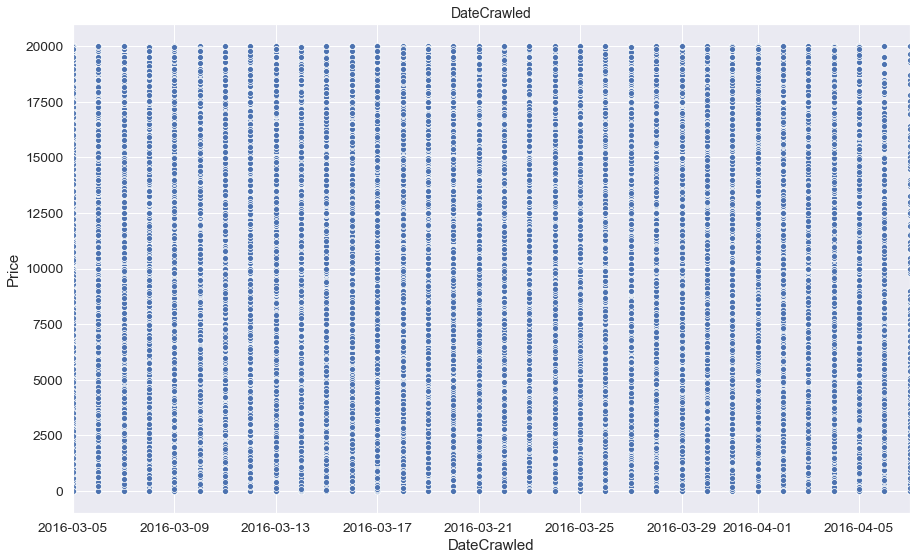

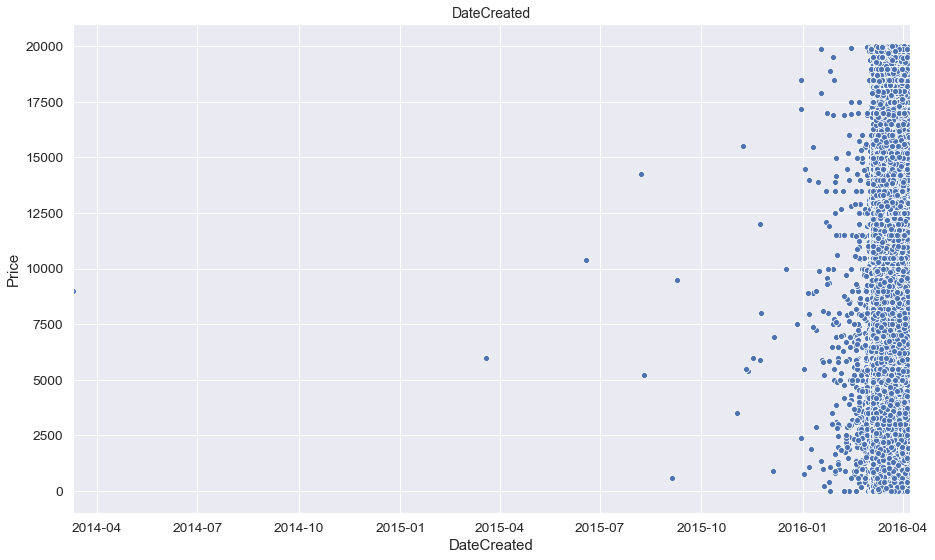

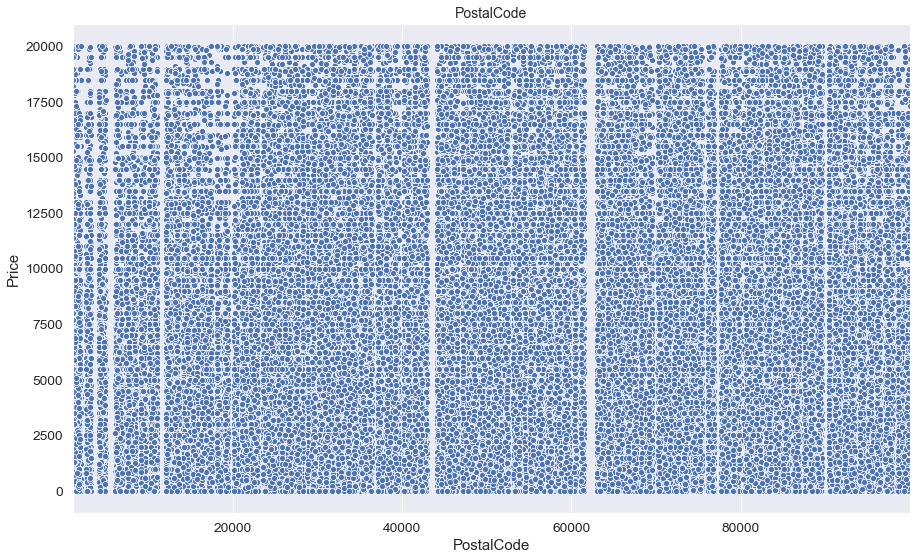

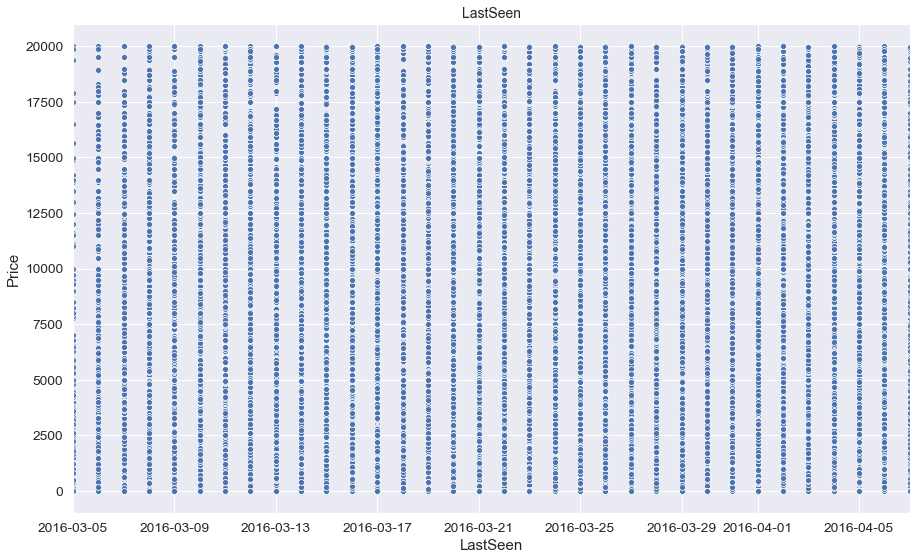

In [13]:
df= data_to_check

for item in data_to_check.columns[:-1]:
    fig, axes = plt.subplots(1, 1, figsize=(15, 9))
    axes = sns.scatterplot(x=item, y=target_name, data=df)
    axes.set_title(item, fontsize=FONT_SIZE)
    axes.set(xlim=(df[item].min(), df[item].max()))

In [14]:
df = data_to_check
item = 'PostalCode'

corr_coeff = np.array(df[[item, target_name]].corr())[0, 1]
print("Pearson correlation coefficient of '{}' and '{}' is {:.4f}.".format( item, target_name, corr_coeff ), "\n")

Pearson correlation coefficient of 'PostalCode' and 'Price' is 0.0761. 



Исследуемые признаки практически не влияют на цену. Удаляем их. Удалим и временный датасет `data_to_check`.

In [15]:
data = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
del data_to_check
data

Price  VehicleType  RegistrationYear Gearbox  Power        Model  \
0         480          NaN              1993  manual      0         golf   
1       18300        coupe              2011  manual    190          NaN   
2        9800          suv              2004    auto    163        grand   
3        1500        small              2001  manual     75         golf   
4        3600        small              2008  manual     69        fabia   
...       ...          ...               ...     ...    ...          ...   
354364      0          NaN              2005  manual      0         colt   
354365   2200          NaN              2005     NaN      0          NaN   
354366   1199  convertible              2000    auto    101       fortwo   
354367   9200          bus              1996  manual    102  transporter   
354368   3400        wagon              2002  manual    100         golf   

        Kilometer  RegistrationMonth  FuelType           Brand NotRepaired  
0          150000                  0    petrol      volkswagen         NaN  
1          125000                  5  gasoline            audi         yes  
2          125000                  8  gasoline            jeep         NaN  
3          150000                  6    petrol      volkswagen          no  
4           90000                  7  gasoline           skoda          no  
...           ...                ...       ...             ...         ...  
354364     150000                  7    petrol      mitsubishi         yes  
354365      20000                  1       NaN  sonstige_autos         NaN  
354366     125000                  3    petrol           smart          no  
354367     150000                  3  gasoline      volkswagen          no  
354368     150000                  6  gasoline      volkswagen         NaN  

[354365 rows x 11 columns]

## 1.5 Наличие пропусков в признаках

Теперь проверим (отдельно ото всех прочих и в первую очередь) наличие пропусков в целевом признаке (`Price`). Здесь нам нужна достоверная информация, поэтому стратегия будет одна - найти пропуски и удалить.

In [16]:
print("The target has {} missing values.".format( data[target_name].isna().sum() ))

The target has 0 missing values.


Теперь проверим все остальные признаки на наличие пропусков.

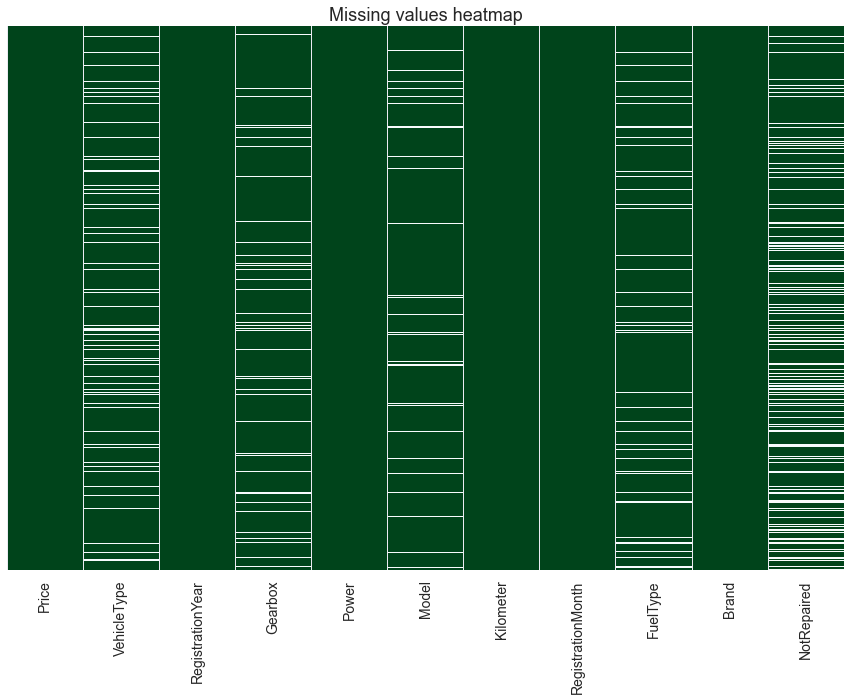

In [17]:
data.isna().sum()

fig, axes = plt.subplots(1, 1, figsize=(15, 10))
cmap = sns.diverging_palette(20, 275, s=80, as_cmap=True)

sns.heatmap(data.isna(), cmap='BuGn_r', cbar = False, yticklabels=False)

plt.xticks(fontsize=FONT_SIZE)
axes.set_title("Missing values heatmap", fontsize=FONT_SIZE+4)
axes.tick_params(axis='y', length=0)#, bottom=False)

In [18]:
print("Maximal amount of missing values ({}, i.e. {:.1%}) is in the '{}'.".format( data.isna().sum().max(), 
                                                                                  data.isna().sum().max()/len(data),
                                                                                  data.isna().sum().idxmax() ))

Maximal amount of missing values (71154, i.e. 20.1%) is in the 'NotRepaired'.


Пропуски есть в 5 признаках: `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired`. Максимальное количество пропусков (71154, i.e. 20.1%) - не так уж и много для довольно большого датасета. К тому же пропуски довольно равномерно распределены по записям. Для того, чтобы понять что делать с пропусками (заполнять/выкидывать записи или вовсе избавится от признака) стоит:
- Изучить корреляцию признака с целевым признаком. Возможно, некоторые признаки не влияют на целевой признак и их можно отбросить.;
- Изучить значения признака. Это может помочь сообразить как заполнять пропуски (`VehicleType`, `Gearbox`, `Model`, `FuelType`).
- Изучить (по возможности$^1$) мультиколлинеарность с другими признаками.

$^1$: Стоит помнить, что для полного рассмотрения мультиколлинеарности потребуется изучить $N_f(N_f-1)/2$ пар `feature[i]`/`feature[j]`. В нашем случае это 55 пар. Хотя если удастся оправданно удалить какие-то признаки, это число уменьшится.

In [19]:
N_f = data.columns
print("There are {} possible pairs of features.".format( int(len(N_f)*(len(N_f)-1)/2) ))

There are 55 possible pairs of features.


Однако!
Больше всего пропусков (71154, i.e. 20.1%) в признаке (была машина в ремонте или нет). Никакого адекватного способа восстановить пропуски в этом признаке нет. Надо удалять записи с пропуском в этом признаке.

Поскольку данных много, удалим ВСЕ пропуски.

<div style="border:solid magenta 2px; padding: 20px"> <h1 style="color:magenta; margin-bottom:20px">Комментарии</h1>

Можно было ввести группу "неизвестно", как вариант. Но надо смотерть, что на выходе с выборкой будет...

In [20]:
data = data.dropna()
print("We have {} entities without missing values.".format(len(data)))

We have 245810 entities without missing values.


У нас по-прежнему достаточно данных для построения модели.

Создадим признак `RegistrationDate` из `RegistrationYear` и `RegistrationMonth`. Нет нужды превращать его в `datetime`. Округлим его до сотых, что позволит различать месяцы и этого будет достаточно. Месяц может показывать сезонность цены

После это признаки `RegistrationYear` и `RegistrationMonth` будут ненужны для построения модели - откажемся от них.

In [21]:
data['RegistrationDate'] = data['RegistrationYear'] + data['RegistrationMonth']/12
data['RegistrationDate'] = data['RegistrationDate'].apply(lambda x: round(x, 2))

data = data.drop(['RegistrationYear', 'RegistrationMonth'], axis=1)

C:\Users\DNS\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\DNS\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 1.6 Исследование признаков

Определим какие признаки являются:
- численными (numerical)
- категориальными (categorical) среди которых есть
  - упорядоченные (ordinal)
  - бинарные (binary)
  - прочие неупорядоченные

In [22]:
features_set = set(data.columns) - set(target_name)

features_numerical = ['Power', 'Kilometer', 'RegistrationDate']
features_numerical_set = set(features_numerical)

features_categorical_set = features_set - features_numerical_set
features_categorical = list(features_categorical_set)

features_ordinal = []
features_ordinal_set = set(features_ordinal)

features_one_hot_set = features_categorical_set - features_ordinal_set
features_one_hot = list(features_one_hot_set)


print("There are {} numerical variables:{}.".format( len(features_numerical), features_numerical ))
print("There are {} categorical variables, among them:\n    {} ordianal variables and\n    {} 'one-hot' variables".
      format( len(features_categorical_set), len(features_ordinal), len(features_one_hot) ))

There are 3 numerical variables:['Power', 'Kilometer', 'RegistrationDate'].
There are 7 categorical variables, among them:
    0 ordianal variables and
    7 'one-hot' variables


### 1.6.1 Анализ численных переменных

Для анализа численных (numerical) данных удобно написать одну функцию, которая
- рисует `sns.boxplot()`: удобно выявлять аномалии
- рисует распределение `sns.distplot()`
- рисует диаграмму рассеяния `sns.scatterplot()` для пары `feature`/`target`: можно выявить зависимости
- вычисляет базовые статистические показатели `.describe()` (среднее, дисперсия, минимальное и максимально значения, квантили)
- сообщает сколько пропущенных значений (missing values)
- вычисляет линейный коэффициент корреляции Пирсона для пары `feature`/`target`

In [23]:
def num_variable_analysis(df, item, target_name, n_bins=100):
    if item != target_name:
        fig, axes = plt.subplots(1, 3, figsize=(15, 10))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    
    
    # ==== FIG 1 (boxplot)    
    df.boxplot(column=item, ax=axes[0])
    axes[0].set_title(item, fontsize=FONT_SIZE)

    
    # ==== FIG 2 (distplot)
    sns.distplot(df[item], bins=n_bins, kde=True, ax=axes[1], vertical=True)
    axes[1].set_title(item, fontsize=FONT_SIZE)
    plt.xticks(rotation=45)
    # axes.set_xlim((0, 100))
    
    
    # === FIG 3 (scatterplot)
    if item != target_name:
        axes[2] = sns.scatterplot(x=item, y=target_name, data=df)
    
    
    # === Descriptive statistics
    describer = pd.DataFrame(df[item].describe()).T    
    print("==== {} ====".format(item))
    print(describer, "\n")
    
    
    # Pearson correlation coefficient for feature/target
    if item != target_name:
        corr_coeff = np.array(df[[item, target_name]].corr())[0, 1]
        print("Pearson correlation coefficient of '{}' and '{}' is {:.4f}.".format( item, target_name, corr_coeff ), "\n")
    
    
    # === Missing values
    print("There are {} missing values in '{}'.".format( df[item].isna().sum(), item ), "\n"*2)

#### 1.6.1.0 Целевой признак ('Price')

==== Price ====
          count         mean          std  min     25%     50%     75%  \
Price  245810.0  5125.391485  4717.970659  0.0  1499.0  3500.0  7500.0   

           max  
Price  20000.0   

There are 0 missing values in 'Price'. 




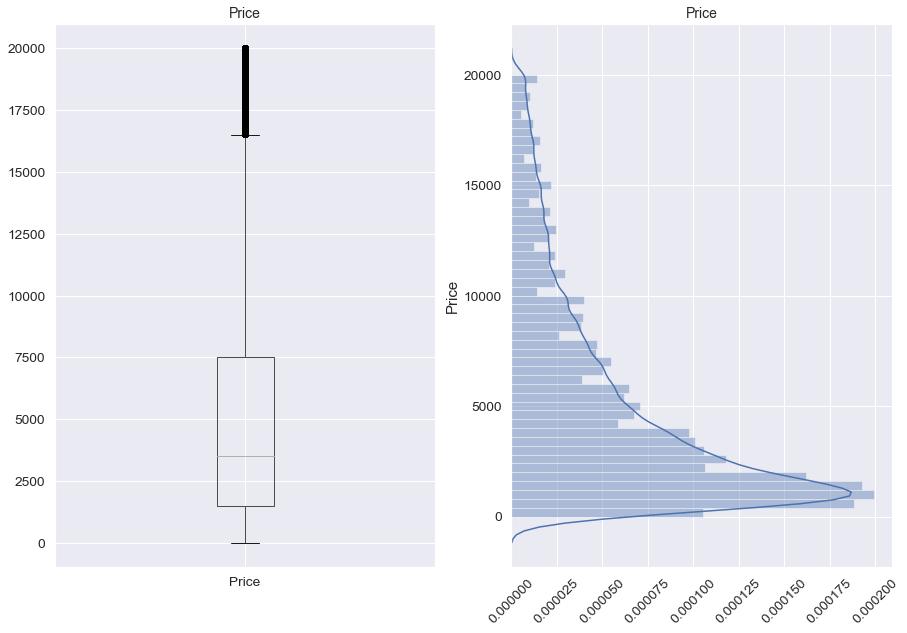

In [24]:
num_variable_analysis(data, target_name, target_name, n_bins=50)

Распределение выглядит вполне разумно. Запредельных аномалий нет. Однако есть значения с нулевой ценой.

Text(0.5, 1.0, 'Distribution for Price less than mean value (5125 euros)')

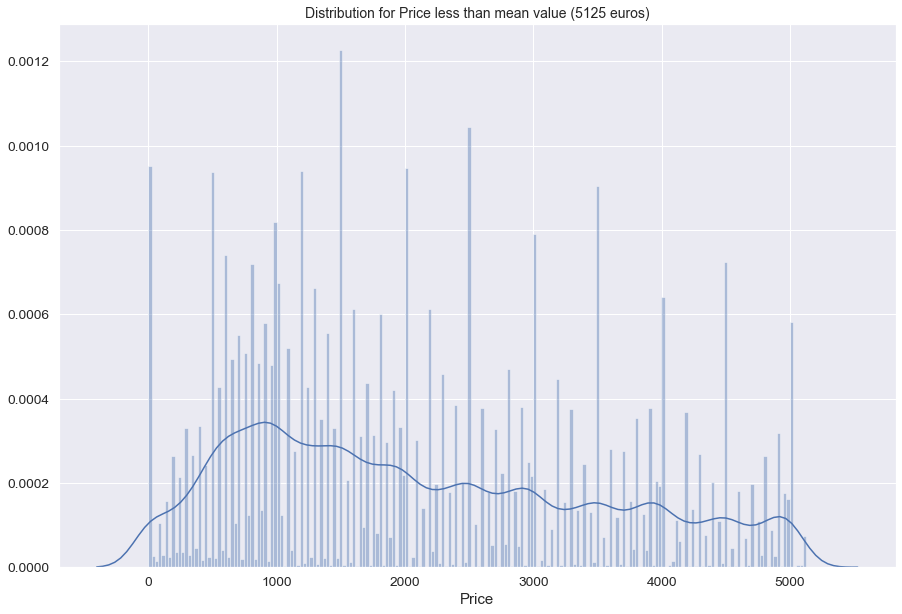

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(15, 10))

sns.distplot(data[ data[target_name] < data[target_name].mean() ][target_name], bins=200, kde=True)
axes.set_title("Distribution for Price less than mean value ({:.0f} euros)".format(data[target_name].mean()), 
               fontsize=FONT_SIZE)

In [26]:
price_less_20 = data[ data[target_name] <20 ][target_name].value_counts()
price_less_20 = pd.DataFrame(price_less_20).reset_index()
price_less_20.columns = ['Price', 'count']
price_less_20 = price_less_20.sort_values('Price')
print("Количество машин с ценами меньше 20 евро")
price_less_20

Количество машин с ценами меньше 20 евро


Price  count
0       0   3386
1       1    340
5       2      4
7       3      2
3       5      5
4       9      4
2      10     12
9      11      1
6      13      3
8      15      1
10     16      1

Обращают на себя аномалии со значениями цены в `0` и `1` евро. Это могут быть и достоверные данные (`0`- "заберите даром", `1` - "отдам за минимальную символическую цену"), однако на фоне соседних цен эти выбросы на пару порядков выше. Вряд ли это нужно нашей модели, скорее подойдёт к ответу на вопрос "какова вероятность купить машину за символическую цену", но... Это не наш вопрос.

Избавимся от записей со значениями цены в `0` и `1` евро.

Text(0.5, 1.0, 'Distribution for Price less than mean value (5204 euros)')

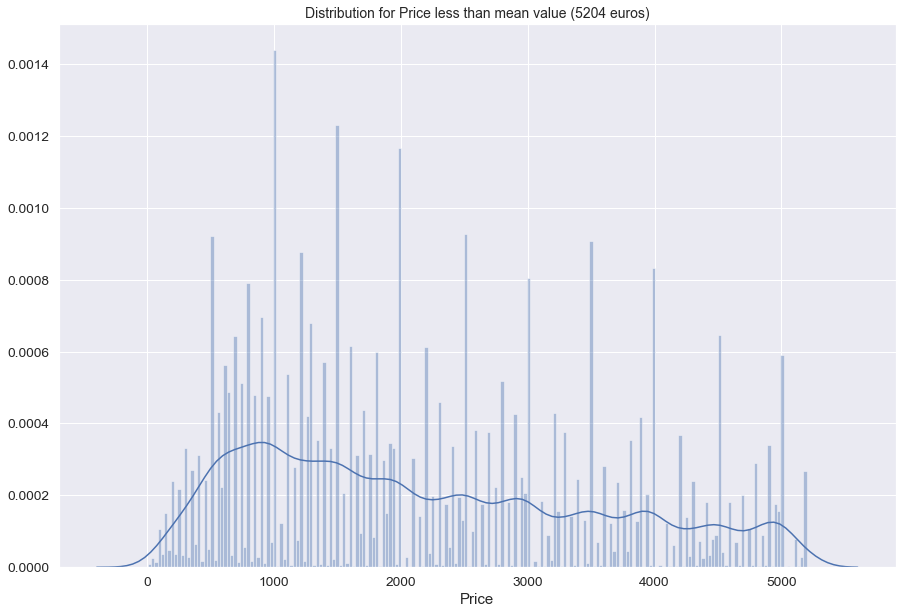

In [27]:
data = data[ data[target_name] > 1 ]

fig, axes = plt.subplots(1, 1, figsize=(15, 10))

sns.distplot(data[ data[target_name] < data[target_name].mean() ][target_name], bins=200, kde=True)
axes.set_title("Distribution for Price less than mean value ({:.0f} euros)".format(data[target_name].mean()), 
               fontsize=FONT_SIZE)

==== Price ====
          count         mean          std  min     25%     50%     75%  \
Price  242084.0  5204.276784  4710.765652  2.0  1500.0  3500.0  7500.0   

           max  
Price  20000.0   

There are 0 missing values in 'Price'. 




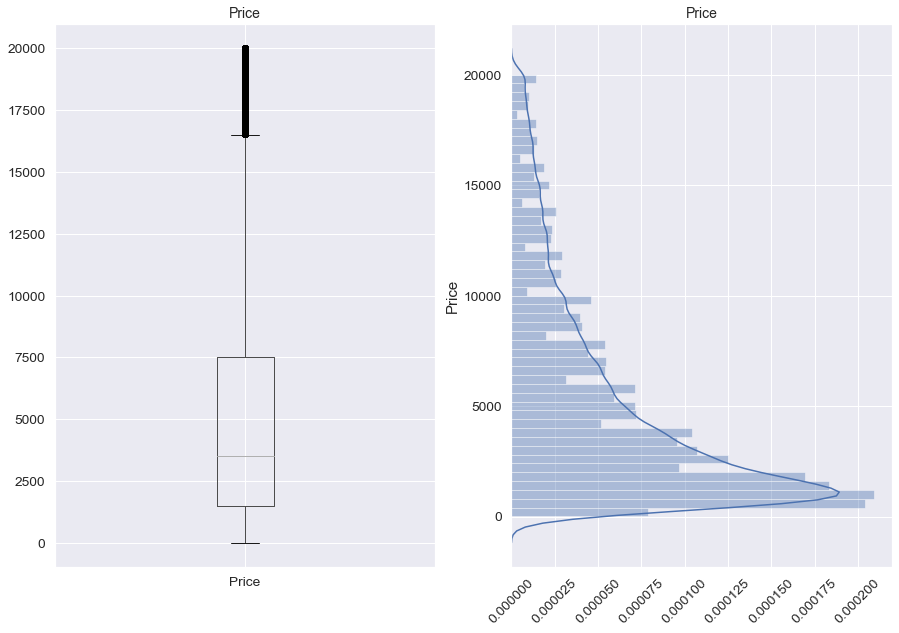

In [28]:
num_variable_analysis(data, target_name, target_name, n_bins=50)

#### 1.6.1.1 Численные признаки

==== Power ====
          count        mean        std  min   25%    50%    75%      max
Power  242084.0  120.126117  137.03109  0.0  75.0  111.0  150.0  20000.0 

Pearson correlation coefficient of 'Power' and 'Price' is 0.2062. 

There are 0 missing values in 'Power'. 


==== Kilometer ====
              count           mean           std     min       25%       50%  \
Kilometer  242084.0  127203.677236  37063.403434  5000.0  125000.0  150000.0   

                75%       max  
Kilometer  150000.0  150000.0   

Pearson correlation coefficient of 'Kilometer' and 'Price' is -0.4020. 

There are 0 missing values in 'Kilometer'. 


==== RegistrationDate ====
                     count        mean       std     min      25%      50%  \
RegistrationDate  242084.0  2003.49474  6.147146  1923.0  1999.75  2003.92   

                      75%     max  
RegistrationDate  2007.83  2019.0   

Pearson correlation coefficient of 'RegistrationDate' and 'Price' is 0.5568. 

There are 0 missing val

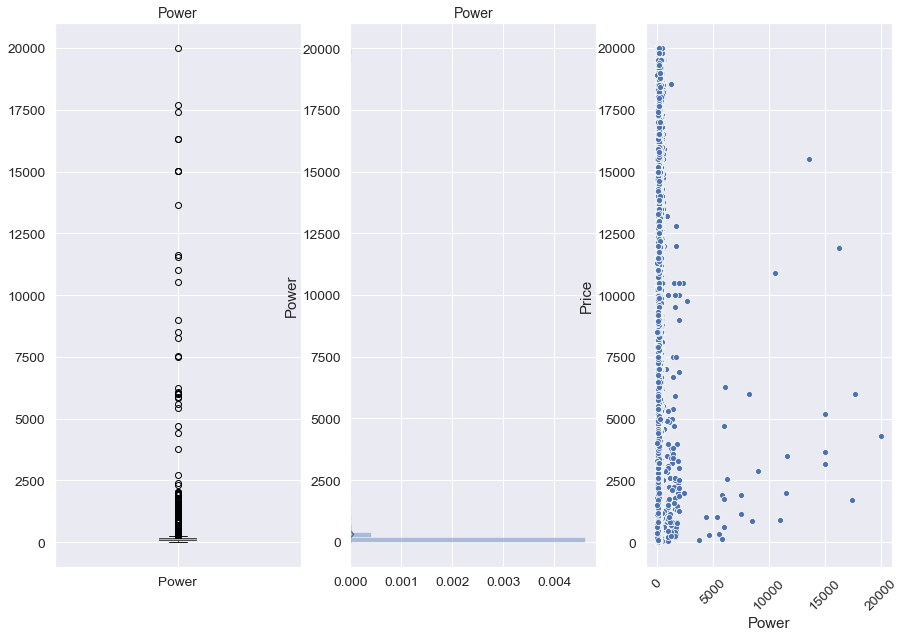

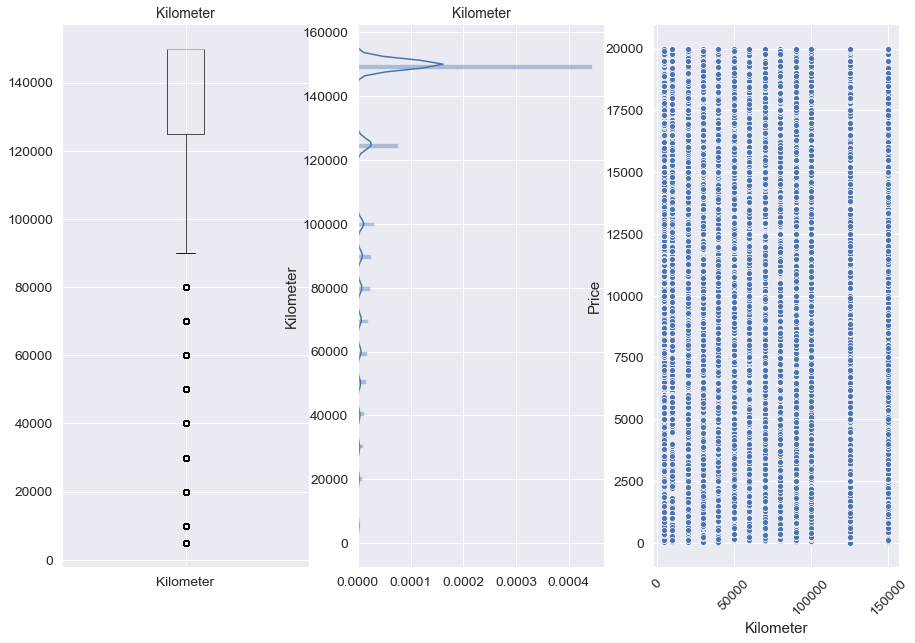

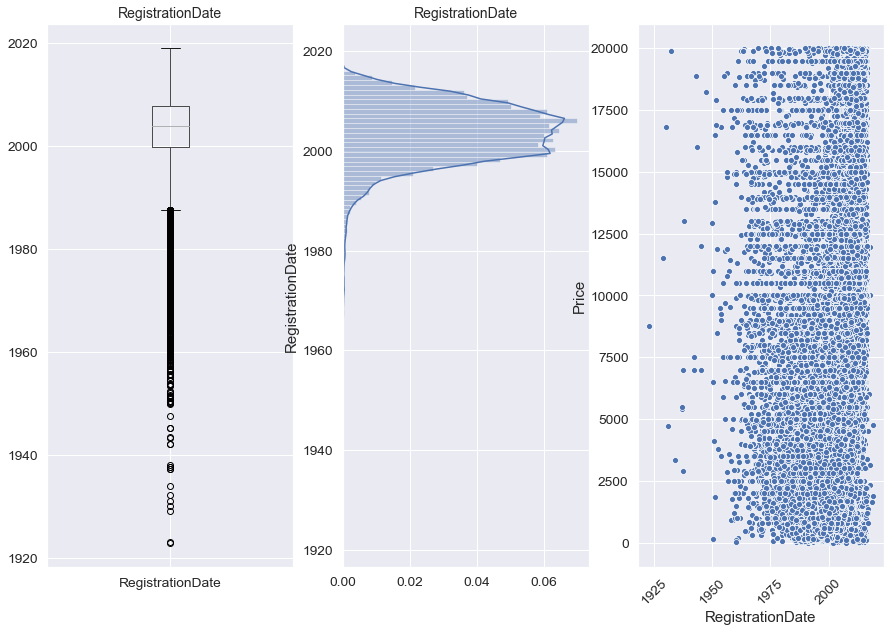

In [29]:
for item in features_numerical:
    num_variable_analysis(data, item, target_name)

**Power (мощность в л.с.)**

В признаке `Power` (мощность в л.с.) наблюдаются аномально высокие значения - мощность двигателя до 20000 л.с.! 

В то время как как самые большие мощности существующих автомобильных моторов :
- 4660 л.с. у карьерного самосвала БелАЗ-75710;
- 750 л.с. у серийного грузовика для дальних перевозок Volvo FH16;
- 1600 л.с. у суперкара класса GT Lamborghini Carbonado GT Mansory.

Text(0.5, 1.0, 'Distribution for Power')

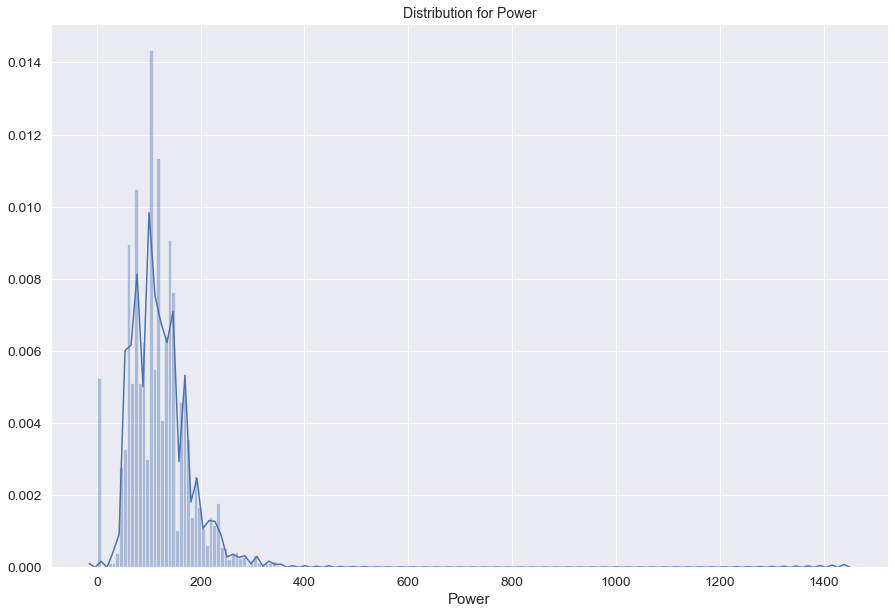

In [30]:
fig, axes = plt.subplots(1, 1, figsize=(15, 10))

item = 'Power'
sns.distplot(data[ data['Power'] < data['Power'].mean()+10*data['Power'].std() ]['Power'], bins=200, kde=True)
axes.set_title("Distribution for {}".format(item), fontsize=FONT_SIZE)

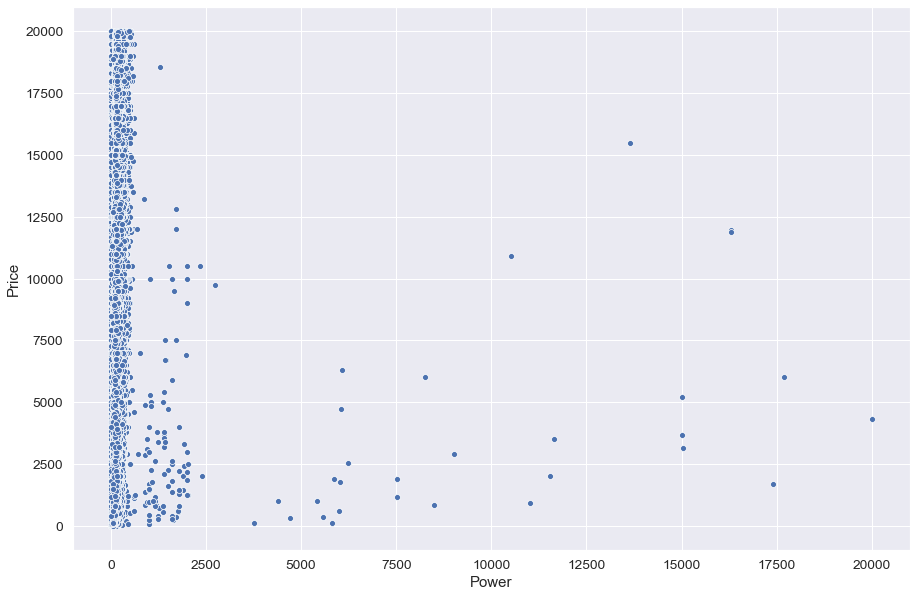

In [31]:
item = 'Power'

fig, axes = plt.subplots(1, 1, figsize=(15, 10))
axes = sns.scatterplot(x=item, y=target_name, data=data)

Price  VehicleType Gearbox  Power     Model  Kilometer  FuelType  \
19092    9750        wagon    auto   2729       5er     150000  gasoline   
25232   10900          bus  manual  10520     caddy     150000  gasoline   
54607     100        small  manual   3750      polo     125000    petrol   
56971    1995        wagon  manual  11530     focus     150000    petrol   
64823   10000        wagon  manual   2005  sprinter     150000  gasoline   
87830    2550        small    auto   6226    fortwo     125000    petrol   
95569    1000        small  manual   4400     ibiza      90000    petrol   
100680   3500        sedan    auto  11635        80     125000    petrol   
113184    350        small  manual   5575      polo     150000    petrol   
129652    300        small  manual   4700      polo     150000    petrol   
134724  10500        wagon    auto   2331        a6     150000  gasoline   
141718    600        sedan  manual   6006    passat     150000    petrol   
143053    120        small  manual   5815    twingo     150000    petrol   
148466   3650        small    auto  15020       147     125000    petrol   
148755   1900        small  manual   5867     agila      70000    petrol   
150676   1700        wagon  manual  17410        80       5000    petrol   
162214   5200        small  manual  15001    fiesta     150000    petrol   
167351   4700        small  manual   6045      polo     125000    petrol   
171089   1750        sedan  manual   6010     agila      90000    petrol   
188113   5999        small  manual   8259     spark      30000    petrol   
196532   6000        wagon    auto  17700       5er     150000  gasoline   
197896    900        wagon  manual  11011        a4     150000  gasoline   
205808   3150        coupe  manual  15033     other       5000  gasoline   
216993  11950  convertible  manual  16312        a4      20000    petrol   
219584   4300        coupe    auto  20000       clk     150000    petrol   
227634  15499        wagon  manual  13636  c_klasse     125000  gasoline   
236199   8999        coupe  manual   2009        tt     150000    petrol   
240066   6299        small  manual   6062        up      50000    petrol   
247802   2000        sedan    auto   2402        a8     150000    petrol   
262321   2500        other    auto   2018      clio      80000     other   
277113   2890          bus  manual   9007     c_max     150000    petrol   
287426   1250        small  manual   2017     punto     150000       cng   
290033   1000        small  manual   5420     corsa     150000    petrol   
296914   1150          bus  manual   7511    kangoo     150000    petrol   
311399  11900        wagon    auto  16311       5er     150000  gasoline   
328862    850        small  manual   8500     corsa     150000    petrol   
341320   1899        other  manual   7518  berlingo     125000    petrol   
348237   3000        coupe  manual   2007     corsa     150000  gasoline   

                Brand NotRepaired  RegistrationDate  
19092             bmw          no           2005.58  
25232      volkswagen          no           2009.50  
54607      volkswagen         yes           1996.33  
56971            ford          no           2002.08  
64823   mercedes_benz          no           2008.08  
87830           smart          no           2004.42  
95569            seat         yes           1996.75  
100680           audi          no           1993.17  
113184     volkswagen         yes           1995.08  
129652     volkswagen         yes           1997.33  
134724           audi          no           2007.83  
141718     volkswagen         yes           1997.58  
143053        renault         yes           1996.75  
148466     alfa_romeo          no           2002.92  
148755           opel          no           2001.50  
150676           audi         yes           1995.00  
162214           ford          no           2006.00  
167351     volkswagen          no           2010.00  
171089           

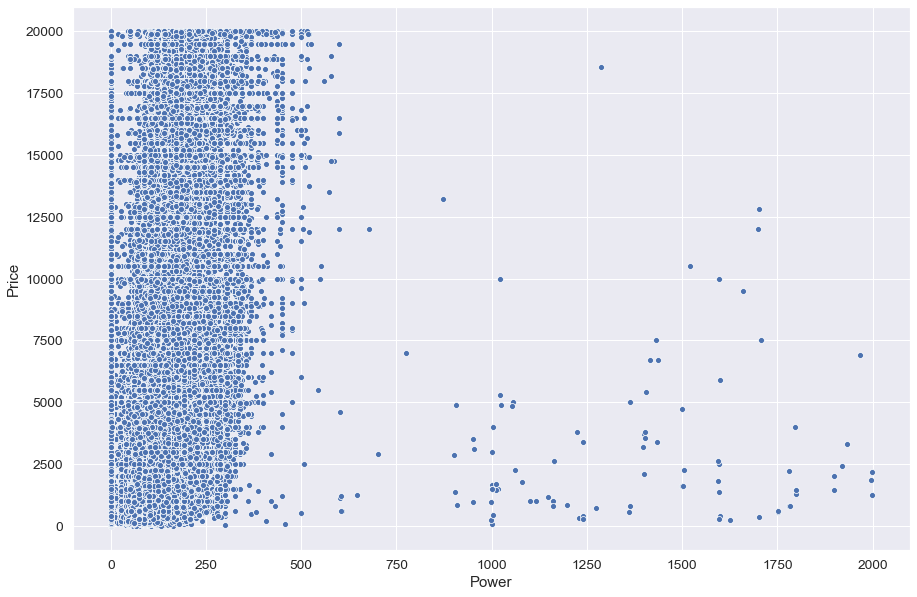

In [32]:
item = 'Power'
threshold = 2000

fig, axes = plt.subplots(1, 1, figsize=(15, 10))
axes = sns.scatterplot(x=item, y=target_name, data=data[ data[item] < threshold ])

data[ data['Power'] > threshold ]

In [33]:
data[ (750 < data['Power']) & (data['Power'] < 1000) ]

Price  VehicleType Gearbox  Power  Model  Kilometer  FuelType  \
4060     3100        sedan  manual    953   colt     150000  gasoline   
12740    3500  convertible  manual    952     ka      70000    petrol   
43556    2850        sedan  manual    900     c4     100000  gasoline   
171619   1350        coupe  manual    903  civic     150000    petrol   
192079  13200        small  manual    871  other      20000    petrol   
193012    825        sedan  manual    909     80     150000    petrol   
195787   7000        small  manual    776  punto      60000  electric   
222640    950        small  manual    950  arosa     150000    petrol   
249460   4899          bus  manual    907  other     150000  gasoline   
260366    950        small  manual    999  other     125000    petrol   
301843    230        small  manual    998  micra     150000    petrol   

             Brand NotRepaired  RegistrationDate  
4060    mitsubishi          no           2005.33  
12740         ford          no           2003.42  
43556      citroen          no           2005.17  
171619       honda          no           1997.75  
192079        opel          no           2013.08  
193012        audi         yes           1985.58  
195787        fiat          no           2009.75  
222640        seat          no           2000.00  
249460     citroen          no           2009.92  
260366     hyundai          no           2001.33  
301843      nissan          no           1993.50

In [34]:
data[ (500 < data['Power']) & (data['Power'] < 750) ]

Price  VehicleType Gearbox  Power     Model  Kilometer  FuelType  \
6296      599        small  manual    603     matiz       5000    petrol   
6637      600        small  manual    603     corsa     150000    petrol   
17510   15500        coupe    auto    507   m_reihe     150000    petrol   
20145   18500          suv    auto    521   cayenne     150000    petrol   
23188   11999        wagon    auto    504     other     150000    petrol   
25684   20000        sedan    auto    507   m_reihe     150000    petrol   
32693   16999        sedan    auto    515        a8     150000    petrol   
73749   18500        sedan    auto    520     other      50000    petrol   
75230   17999        sedan    auto    560   m_reihe      40000    petrol   
92566   20000        sedan    auto    507   m_reihe     150000    petrol   
94999   19490        sedan    auto    517  s_klasse     150000    petrol   
102613  19500        coupe    auto    600     other       5000    petrol   
105658  19000        wagon    auto    579     other     150000    petrol   
120559   9999        coupe  manual    550      golf     150000    petrol   
122594  13750        wagon    auto    520        a6      80000    petrol   
124994  12900        wagon    auto    504     other     150000    petrol   
138169  19900        coupe    auto    519       clk     125000    petrol   
138257  14750        sedan    auto    585  e_klasse     150000    petrol   
149019   8999        sedan    auto    507   m_reihe     100000    petrol   
155997  16500        wagon    auto    510     other     125000    petrol   
156234  19500        coupe  manual    525   mustang      10000    petrol   
158083  16000          suv    auto    510  m_klasse     125000    petrol   
161196  15500        coupe    auto    507   m_reihe     150000    petrol   
162334  18900        sedan    auto    514  e_klasse     150000    petrol   
162460  12000        sedan    auto    600    s_type     150000    petrol   
173074  11900          suv    auto    521   cayenne     125000    petrol   
176792  18000          suv    auto    510  m_klasse     125000       lpg   
177451  11999        wagon    auto    505     other     150000    petrol   
177455    600        small    auto    606     corsa     150000    petrol   
180840   1100        small    auto    601      polo     150000    petrol   
186427  16500        coupe  manual    600     other       5000    petrol   
208144  19999        coupe    auto    514     other     150000    petrol   
218406  14500        wagon    auto    510     other     150000    petrol   
220133  12000        small  manual    678       500      30000    petrol   
222381  17000        sedan    auto    515        a8     150000    petrol   
227383   1200        sedan  manual    603      golf     150000  gasoline   
241096   2500        coupe    auto    507   m_reihe     125000    petrol   
243042  15900        sedan    auto    600  s_klasse     150000    petrol   
243754  13500        sedan  manual    572    vectra      20000    petrol   
249174   5499        sedan  manual    544      golf     150000    petrol   
249238   1250          suv  manual    645     other     150000    petrol   
252980   2885  convertible  manual    702       500      50000    petrol   
260605  15000        sedan    auto    507       5er     150000    petrol   
264192  19900        sedan    auto    517  s_klasse     150000    petrol   
304064  14900        sedan    auto    514  e_klasse     150000    petrol   
307452  18200        wagon    auto    579     other     150000    petrol   
308872  16500        coupe    auto    508        cl      50000    petrol   
311474  10500        coupe  manual    551     other      90000    petrol   
313123  15700        sedan    auto    514  e_klasse     150000    petrol   
320093  15500        coupe    auto    507   m_reihe     150000    petrol   
320566  14750        wagon    auto    579     other     150000    petrol   
328276  16500        sedan    auto    507   m_reihe     

In [35]:
data[ (300 < data['Power']) & (data['Power'] < 500) ]

Price  VehicleType Gearbox  Power     Model  Kilometer  FuelType  \
172     19750  convertible  manual    305   mustang      50000    petrol   
204     18400        wagon    auto    313       5er     150000  gasoline   
485     15200        sedan    auto    320  s_klasse     150000  gasoline   
653     12999        sedan    auto    306  s_klasse      90000    petrol   
694     13800        sedan    auto    333       5er     150000    petrol   
...       ...          ...     ...    ...       ...        ...       ...   
353676   5800        sedan    auto    326       7er     150000    petrol   
353837  12000        sedan  manual    321   m_reihe     150000    petrol   
353985  17999        coupe  manual    343   m_reihe     150000    petrol   
354045  20000        coupe    auto    476     other     125000    petrol   
354067  11500        wagon    auto    340      300c     150000    petrol   

                Brand NotRepaired  RegistrationDate  
172              ford          no           2006.58  
204               bmw          no           2011.92  
485     mercedes_benz          no           2007.58  
653     mercedes_benz          no           2003.00  
694               bmw          no           2005.67  
...               ...         ...               ...  
353676            bmw         yes           2000.25  
353837            bmw          no           1997.58  
353985            bmw          no           2002.33  
354045  mercedes_benz          no           2006.58  
354067       chrysler          no           2005.33  

[2232 rows x 10 columns]

Можно было бы ограничиться данными для машин с мощностью двигателя до 750 л.с. Здесь уже есть реально существующие "мустанги" и BMW серии M.

Хотя ошибочных данных будет всё же не так уж и мало. Подумаем о них чуть позже. 

<div style="border:solid magenta 2px; padding: 20px"> <h1 style="color:magenta; margin-bottom:20px">Комментарии</h1>

Можно было бы написать функцию, восстанавливающую пропуски (и подозрительные значения) поиском совпадений по прочим признакам (список столбцов, передаваемый как аргумент).

In [36]:
data = data[ data['Power'] < 750 ]

==== Power ====
          count        mean        std  min   25%    50%    75%    max
Power  241952.0  118.349764  57.684642  0.0  75.0  111.0  150.0  702.0 

Pearson correlation coefficient of 'Power' and 'Price' is 0.4949. 

There are 0 missing values in 'Power'. 


==== Kilometer ====
              count           mean           std     min       25%       50%  \
Kilometer  241952.0  127206.946006  37057.335522  5000.0  125000.0  150000.0   

                75%       max  
Kilometer  150000.0  150000.0   

Pearson correlation coefficient of 'Kilometer' and 'Price' is -0.4022. 

There are 0 missing values in 'Kilometer'. 


==== RegistrationDate ====
                     count         mean       std     min      25%      50%  \
RegistrationDate  241952.0  2003.495273  6.147546  1923.0  1999.75  2003.92   

                      75%     max  
RegistrationDate  2007.83  2019.0   

Pearson correlation coefficient of 'RegistrationDate' and 'Price' is 0.5568. 

There are 0 missing value

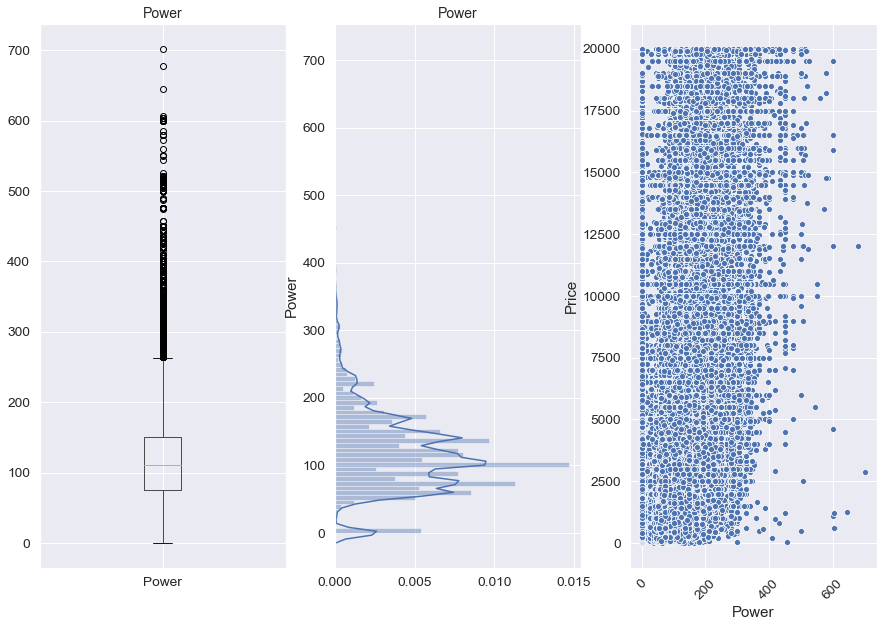

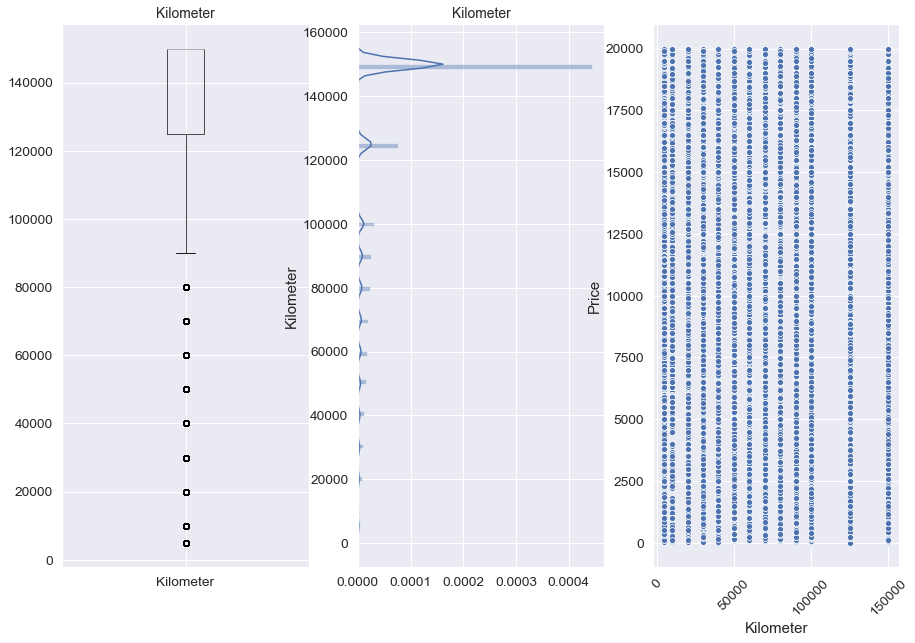

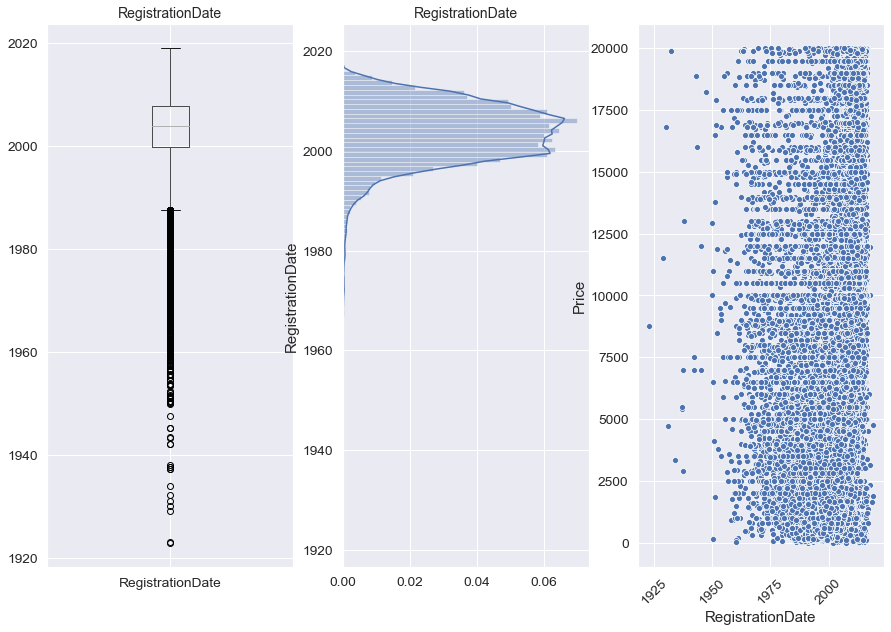

In [37]:
for item in features_numerical:
    num_variable_analysis(data, item, target_name)

**Kilometer (пробег в км)**

Обращает на себя внимание "квантованность" значений признака `Kilometer` (пробег в км). При этом максимум соответствует максимально возможному указанному пробегу (160000 км), что очевидно соответствует не численной переменной, а категориальной (ordinal). В остальном никаких аномалий не выявлено. Переквалифицируем признак `Kilometer` в  `ordinal`.

In [38]:
item = 'Kilometer'

print("there are {} unique values for the feature {}.".format( data[item].nunique(), item ))
data['Kilometer'].value_counts()

there are 13 unique values for the feature Kilometer.


150000    156090
125000     27047
100000     10996
90000       8998
80000       7942
70000       6859
60000       6098
50000       5091
40000       4050
30000       3466
20000       2775
5000        1724
10000        816
Name: Kilometer, dtype: int64

In [39]:
data.columns

Index(['Price', 'VehicleType', 'Gearbox', 'Power', 'Model', 'Kilometer',
       'FuelType', 'Brand', 'NotRepaired', 'RegistrationDate'],
      dtype='object')

In [40]:
features_set = set(data.columns[1:]) - set(target_name)

features_numerical = ['Power', 'RegistrationDate']
features_numerical_set = set(features_numerical)

features_categorical_set = features_set - features_numerical_set
features_categorical = list(features_categorical_set)

features_ordinal = ['Kilometer']
features_ordinal_set = set(features_ordinal)

features_one_hot_set = features_categorical_set - features_ordinal_set
features_one_hot = list(features_one_hot_set)


print("There are {} numerical variables: {}.".format( len(features_numerical), features_numerical ))
print("There are {} categorical variables, among them:\n    {} ordianal variables: {} and".
      format( len(features_categorical_set), len(features_ordinal), features_ordinal ))
print("    {} 'one-hot' variables: {}.".
      format( len(features_one_hot), features_one_hot ))

There are 2 numerical variables: ['Power', 'RegistrationDate'].
There are 7 categorical variables, among them:
    1 ordianal variables: ['Kilometer'] and
    6 'one-hot' variables: ['FuelType', 'Model', 'Brand', 'Gearbox', 'NotRepaired', 'VehicleType'].


**RegistrationDate (дата регистрации автомобиля)**

Text(0.5, 1.0, 'Distribution by age for oldmobiles')

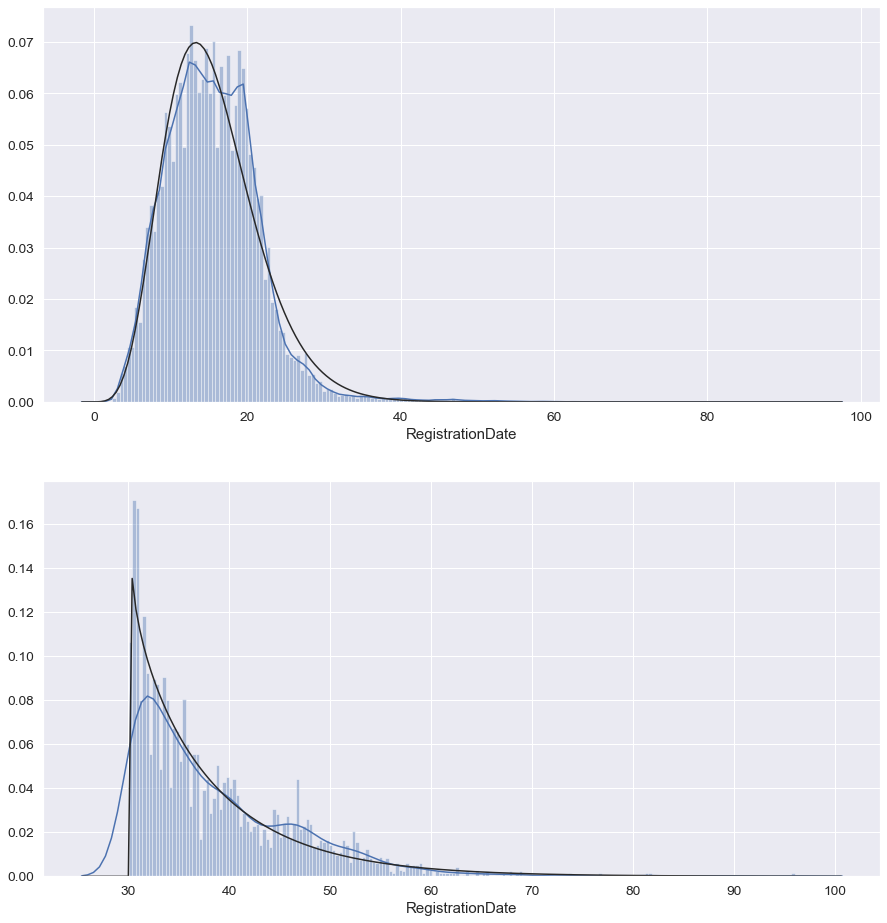

In [41]:
age = data['RegistrationDate'].max() - data['RegistrationDate']

fig, axes = plt.subplots(2, 1, figsize=(15, 16))

plt.subplot(2, 1, 1)
sns.distplot(age, bins=200, kde=True, fit=gamma)
axes[0].set_title("Distribution by age", fontsize=FONT_SIZE)

plt.subplot(2, 1, 2)
sns.distplot(age[ age>30 ], bins=200, kde=True, fit=gamma)
axes[1].set_title("Distribution by age for oldmobiles", fontsize=FONT_SIZE)

Данные вполне адекватны. И общее распределение и распределение олдмобилей (с 1990 до 1923 года выпуска) выглядит разумно. Распределение довольно неплохо аппроксимируется $\Gamma$-распределением.

*Под олдмобилями будем понять машины старше 30 лет (европейское определение).*

In [42]:
OLDTIME = 1990 # = 2020-30
print("The oldest auto was registered in {}.".format( int(data['RegistrationDate'].min()) ))
print("The newest auto was registered in {}.".format( int(data['RegistrationDate'].max()) ))

The oldest auto was registered in 1923.
The newest auto was registered in 2019.


Всего 4902 машин, выпущенных ранее 1990 г.


C:\Users\DNS\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


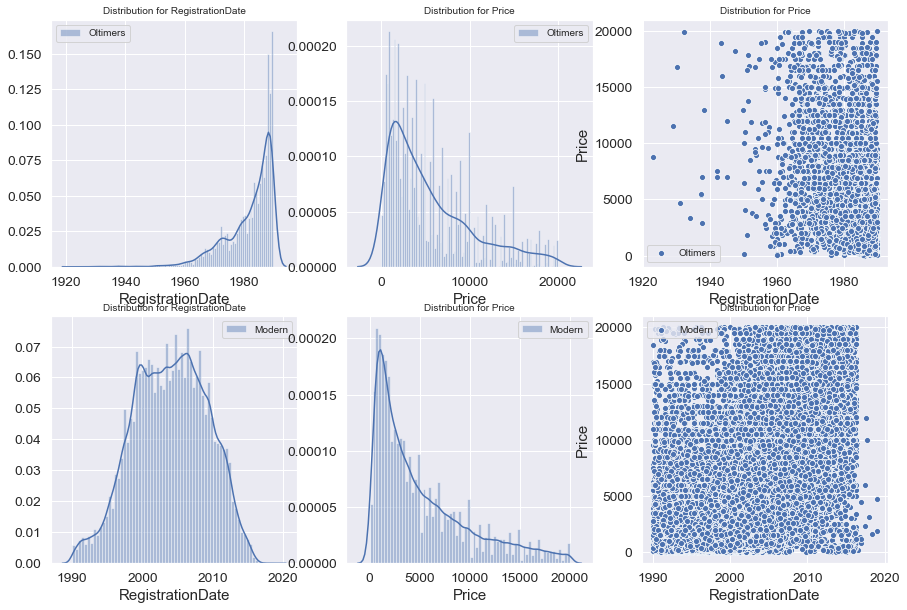

In [43]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

item = 'RegistrationDate'

sns.distplot(data[data[item] < OLDTIME][item], ax=axes[0][0],
             bins=100, kde=True, label='Oltimers')
axes[0][0].legend(fontsize=FONT_SIZE-4)
axes[0][0].set_title("Distribution for {}".format(item), fontsize=FONT_SIZE-4)

sns.distplot(data[data[item] >= OLDTIME][item],  ax=axes[1][0],
             bins=1990-1923+1, kde=True, label='Modern')
axes[1][0].legend(fontsize=FONT_SIZE-4)
axes[1][0].set_title("Distribution for {}".format(item), fontsize=FONT_SIZE-4)

sns.distplot(data[data[item] < OLDTIME][target_name],  ax=axes[0][1],
             bins=100, kde=True, label='Oltimers')
axes[0][1].legend(fontsize=FONT_SIZE-4)
axes[0][1].set_title("Distribution for {}".format(target_name), fontsize=FONT_SIZE-4)


sns.distplot(data[data[item] >= OLDTIME][target_name],  ax=axes[1][1],
             bins=1990-1923+1, kde=True, label='Modern')
axes[1][1].legend(fontsize=FONT_SIZE-4)
axes[1][1].set_title("Distribution for {}".format(target_name), fontsize=FONT_SIZE-4)

sns.scatterplot(x=item, y=target_name, data=data[data[item] < OLDTIME], ax=axes[0][2], label='Oltimers')
axes[0][2].legend(fontsize=FONT_SIZE-4)
axes[0][2].set_title("Distribution for {}".format(target_name), fontsize=FONT_SIZE-4)


sns.scatterplot(x=item, y=target_name, data=data[data[item] >= OLDTIME], ax=axes[1][2], label='Modern')
axes[1][2].legend(fontsize=FONT_SIZE-4)
axes[1][2].set_title("Distribution for {}".format(target_name), fontsize=FONT_SIZE-4)


print("Всего {} машин, выпущенных ранее {} г.".format( data[data[item] < OLDTIME][item].count(),
                                                     OLDTIME ))

### 1.6.2 Категориальные признаки

Узнаем количество уникальных значений для категориальных переменных.

In [44]:
categorical_unique = data[features_categorical].nunique().sort_values(ascending=False)
categorical_unique

Model          249
Brand           39
Kilometer       13
VehicleType      8
FuelType         7
NotRepaired      2
Gearbox          2
dtype: int64

Из двух категориальных неупорядоченных признаков `Brand` и `Model` образуем один - `Model_Name`, поскольку цена определяется конкретной моделью конкретного производителя, то есть сочетанием этих двух признаков. 

Так модель `other` встречается у многих производителей, но очевидно, что это - разные модели. Поэтому, в частности, число уникальных значений признака `Model_Name` больше суммы уникальных значений признаков `Brand` и `Model`.

In [45]:
data['Model_Name'] = data['Brand'] + "-" + data['Model']
data = data.drop(['Brand', 'Model'], axis=1)

In [46]:
unique_names = pd.DataFrame(data['Model_Name'].unique(), columns=['Model_Name'])
unique_names.sort_values('Model_Name')#.values

Model_Name
275    alfa_romeo-145
48     alfa_romeo-147
34     alfa_romeo-156
143    alfa_romeo-159
224  alfa_romeo-other
..                ...
51          volvo-v40
166         volvo-v50
269         volvo-v60
205         volvo-v70
190    volvo-xc_reihe

[296 rows x 1 columns]

In [47]:
features_set = set(data.columns[1:]) - set(target_name)

features_numerical = ['Power', 'RegistrationDate']
features_numerical_set = set(features_numerical)

features_categorical_set = features_set - features_numerical_set
features_categorical = list(features_categorical_set)

features_ordinal = ['Kilometer']
features_ordinal_set = set(features_ordinal)

features_one_hot_set = features_categorical_set - features_ordinal_set
features_one_hot = list(features_one_hot_set)


print("There are {} numerical variables: {}.".format( len(features_numerical), features_numerical ))
print("There are {} categorical variables, among them:\n    {} ordianal variables: {} and".
      format( len(features_categorical_set), len(features_ordinal), features_ordinal ))
print("    {} 'one-hot' variables: {}.".
      format( len(features_one_hot), features_one_hot ))

There are 2 numerical variables: ['Power', 'RegistrationDate'].
There are 6 categorical variables, among them:
    1 ordianal variables: ['Kilometer'] and
    5 'one-hot' variables: ['FuelType', 'Model_Name', 'Gearbox', 'NotRepaired', 'VehicleType'].


In [48]:
categorical_unique = data[features_categorical].nunique().sort_values(ascending=False)
categorical_unique

Model_Name     296
Kilometer       13
VehicleType      8
FuelType         7
NotRepaired      2
Gearbox          2
dtype: int64

In [49]:
print("We have {} binary variables: {}.".format( categorical_unique[ categorical_unique == 2 ].count(), 
                                                list(categorical_unique[ categorical_unique == 2 ].index) ))
print("There are {} variables: {}, which have maximal number ({}) of unique values."
      .format(categorical_unique[ categorical_unique == categorical_unique.max() ].count(), 
              list(categorical_unique[ categorical_unique == categorical_unique.max() ].index),
              categorical_unique.max()))

We have 2 binary variables: ['NotRepaired', 'Gearbox'].
There are 1 variables: ['Model_Name'], which have maximal number (296) of unique values.


In [50]:
for item in ['VehicleType', 'FuelType']:
    print(data[item].value_counts(), "\n")

sedan          71110
small          57956
wagon          50337
bus            23393
convertible    16058
coupe          11918
suv             9534
other           1646
Name: VehicleType, dtype: int64 

petrol      159703
gasoline     77672
lpg           3836
cng            447
hybrid         178
other           65
electric        51
Name: FuelType, dtype: int64 



#### 1.6.2.1 Ordinal features

**Function for analysis of ordinal variables**

Для анализа упорядоченных категориальных (ordinal) данных удобно написать одну функцию, которая
- рисует `sns.barplot()`: фактически распределение, удобно выявлять дисбаланс классов
- рисует `sns.boxplot()` для каждого класса: удобно выявлять аномалии внутри классов
- рисует распределения `sns.kdeplot()` для каждого класса: удобно сравнивать классы (`sns.distplot()` оказался неинформативным из-за сильного перекрытия)
- вычисляет линейный коэффициент корреляции Пирсона для пары `feature`/`target`
- выводит количество значений целевого признака для каждого класса: удобно выявлять аномалии, даёт общее представлении о частности каждого класса
- сообщает сколько пропущенных значений (missing values)

In [51]:
def ordinal_variable_analysis(df, item, target_name):
    fig, axes = plt.subplots(1, 3, figsize=(15, 10))
    
    # ==== FIG 1 (barplot)
    bar_data = df.groupby(item)[item].count()
    br_plot = sns.barplot(x=bar_data.index, y=bar_data, ax = axes[0], palette="Blues_d")
    br_plot.set_xticklabels(bar_data.index, rotation=45)
    axes[0].set_title(item, fontsize=FONT_SIZE)
    
    
    # ==== FIG 2 (boxplots for classes)
    bx_plot = sns.boxplot(x=item, y=target_name, data=df, ax=axes[1])    
    bx_plot.set_xticklabels(bar_data.index, rotation=45)
    plt.xticks(rotation=45)
    axes[1].set_title(item, fontsize=FONT_SIZE)

        
    # ==== FIG 3 (kdeplots for classes)
    values = df[item].value_counts()
    
    for value in values.index:
        sns.kdeplot(df[ df[item] == value ][target_name], vertical=True, ax=axes[2], label=value)
    axes[2].set_title(item, fontsize=FONT_SIZE)
    axes[2].legend(fontsize=FONT_SIZE)
    
    
    # === Descriptive statistics
    
    print("==== {} ====\n".format(item))
    if item != target_name:
        print("Pearson correlation coefficient of '{}' and '{}' is {:.4f}."
              .format( item, 
                      target_name, 
                      np.array(df[[item, target_name]].corr())[0, 1] ), "\n")
    
    print(bar_data, "\n")
    
    print("There are {} missing values in '{}'.".format( df[item].isna().sum(), item ), '\n'*2)

==== Kilometer ====

Pearson correlation coefficient of 'Kilometer' and 'Price' is -0.4022. 

Kilometer
5000        1724
10000        816
20000       2775
30000       3466
40000       4050
50000       5091
60000       6098
70000       6859
80000       7942
90000       8998
100000     10996
125000     27047
150000    156090
Name: Kilometer, dtype: int64 

There are 0 missing values in 'Kilometer'. 




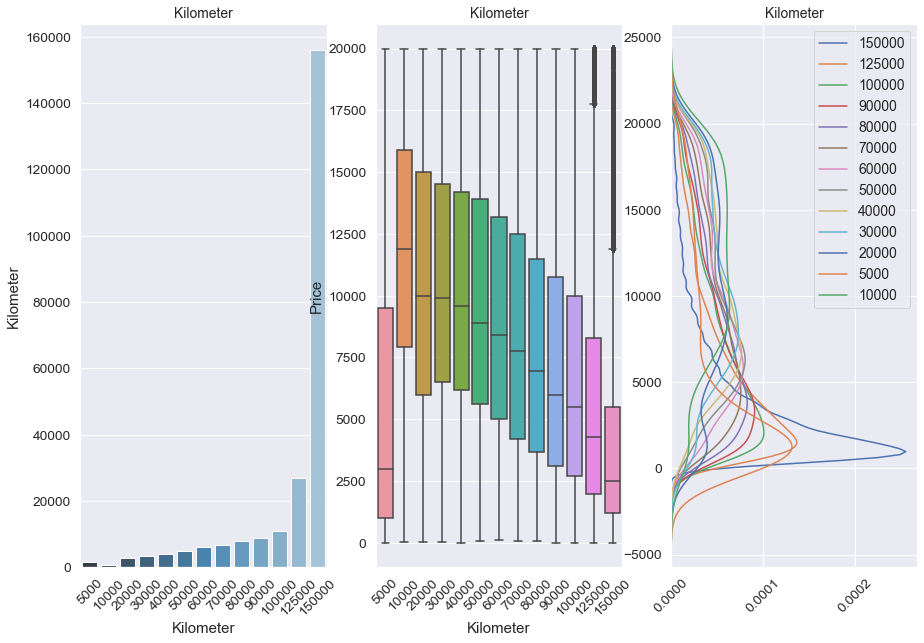

In [52]:
for item in features_ordinal:
    ordinal_variable_analysis(data, item, target_name)

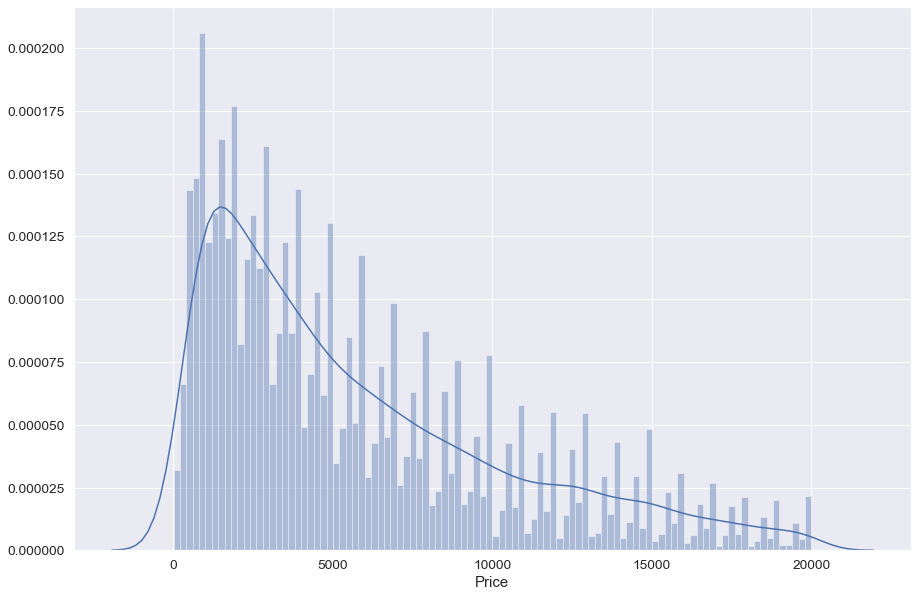

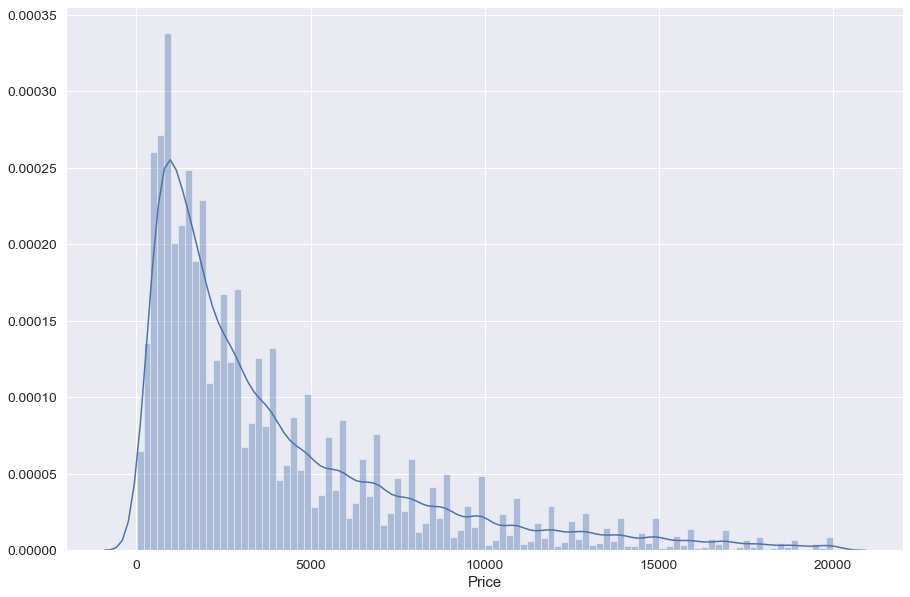

In [53]:
df = data
item = 'Kilometer'

for value in [125000, 150000]:
    fig, axes = plt.subplots(1, 1, figsize=(15, 10))
    sns.distplot(df[ df[item] == value ][target_name], bins=100, label=value)

Аномалий нет. То, что казалось выбросами для значений `125000` и `150000` на 'boxplot',  вполне разумно выглядит на распределениях.

#### 1.6.2.2 One-Hot features

Вопрос о корреляции бинарных переменных с целевым признаком, вообще говоря, не так уж и прост. Коэффициент корреляции Пирсона здесь не применим. Сформулируем задачу следующим образом:
- Есть ли статитстически значимая разница между распределением признаков для двух различных значений бинарной переменной. 

Тут могут помочь статистические тесты на равенство дисперсий, средних значений и т.п.

Важно также проверить вопрос о сбалансированности двух классов. Будем считать классы несбалансированные, если:
- расположив классы по убыванию частности
- отношение частности двух соседних классов больше `3`.

Число `3` во многом волюнтаристское, хотя можно привести в его защиту следующие аргументы:
- для экспоненциальных законов (например, затухания) характерная величина (время затухания) есть такая величина, при изменении на которую функция меняется в $e\simeq 2.72$ раз
- изменение на половину десятичного порядка есть изменение в $10^{0.5}\simeq 3.16$ раз, и это есть граница для округления "по порядку величины"
- $\pi\simeq 3.14$ - тоже красивое число
- ...

Так, что взяв среднее арифметическое / геометрическое / гармоническое (3.01 / 3.00 / 2.99 ), округлим его до `3` (*минутка юмора*).

**Function for analysis of One-Hot variables**

Анализ *One-Hot* переменных во многом похож на анализ *Ordinal* переменных. Различия лишь в:
- здесь удобнее строить `sns.distplot()` вместо `sns.kdeplot()` для каждого класса 
- не вычисляется линейный коэффициент корреляции Пирсона для пары `feature`/`target`
- вычисляется базовые статистические показатели `.describe()` (среднее, дисперсия, минимальное и максимально значения, квантили) для каждого класса, а также средние и средне-квадратичные отклонения (по классам) от этих величин, чтобы сравнивать распределения классов
- вычисляется дисбаланс классов: классы ранжируются по частотности и вычисляются отношения частотности класса к частотности предыдущего; вычисляется максимальное отношение; если оно превышает порог - выводится предупреждение о возможном дисбалансе классов.


Для анализа упорядоченных категориальных (One-Hot) данных написана функцию, которая
- рисует `sns.barplot()`: фактически распределение, удобно выявлять дисбаланс классов
- рисует `sns.boxplot()` для каждого класса: удобно выявлять аномалии внутри классов
- рисует распределения `sns.distplot()` для каждого класса
- выводит количество значений целевого признака для каждого класса: удобно выявлять аномалии, даёт общее представлении о частности каждого класса
- вычисляется базовые статистические показатели `.describe()` (среднее, дисперсия, минимальное и максимально значения, квантили) для каждого класса, а также средние и средне-квадратичные отклонения (по классам) от этих величин, чтобы сравнивать распределения классов
- вычисляется дисбаланс классов: классы ранжируются по частотности и вычисляются отношения частотности класса к частотности предыдущего
- вычисляется дисбаланс классов: классы ранжируются по частотности и вычисляются отношения частотности класса к частотности предыдущего; вычисляется максимальное отношение; если оно превышает порог - выводится предупреждение о возможном дисбалансе классов. **Возвращает** это максимальное отношение$^1$.
- сообщает сколько пропущенных значений (missing values)

$^1$ *Используя это значение, впоследствии формируется список категориальных неупорядоченных признаков, подозреваемых в дисбалансе классов вместе с "порогом подозреваемости".*

In [54]:
def rounder(x, m=2):
    return round(x, m)

def one_hot_variable_analysis(df, item, target_name, n_bins=100, class_balance_threshold=3):
    if item != target_name:
        fig, axes = plt.subplots(1, 3, figsize=(15, 10))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    
    
    # ==== FIG 1 (barplot)
    bar_data = df.groupby(item)[item].count().sort_values(ascending=False)
    br_plot = sns.barplot(x=bar_data.index, y=bar_data, ax = axes[0], palette="Blues_d")
    br_plot.set_xticklabels(bar_data.index, rotation=45)
    axes[0].set_title(item, fontsize=FONT_SIZE)
    
    # ==== FIG 2 (boxplot)
    bx_plot = sns.boxplot(x=item, y=target_name, data=df, ax=axes[1])
    bx_plot.set_xticklabels(bar_data.index, rotation=45)
    axes[1].set_title(item, fontsize=FONT_SIZE)

    
    # ==== FIG 3 (distplot)
    values = df[item].value_counts()
    
    for value in values.index:
        sns.distplot(df[ df[item] == value ][target_name], bins=n_bins, kde=True, norm_hist=True, 
                     vertical=True, ax=axes[2], label=value)
    
    axes[2].set_title(item, fontsize=FONT_SIZE)
    axes[2].legend(fontsize=FONT_SIZE)
    
    
    # === Descriptive statistics    
    
    print("==== {} ====\n".format(item))
    
    
    print(bar_data, "\n")
    
    
    values = df[item].value_counts()
    k = 0
    for value in values.index:
        describer_value = pd.DataFrame(df[ df[item] == value ][target_name].describe())
#         ! print("!!!\n", values, "\n")
        if k == 0:
            describer = describer_value.copy()
        else:
            describer = pd.concat([describer, describer_value], axis=1)
        k += 1    
    describer.columns = values.index
    describer = describer.T
    describer_moments = pd.DataFrame([describer.mean(), describer.std()], index=['MEAN', 'STD'])
    describer = pd.concat([describer, describer_moments], axis=0)
    describer = describer.apply(rounder)
    print(describer, "\n")       
    
    
    print("Class balance ratio (to previous):")
    bar_data_sorted = bar_data.sort_values()
    class_balance_ratio = round(np.exp(np.log(bar_data_sorted).diff()), 2)
    print(class_balance_ratio, "\n")    
    if class_balance_ratio.max() > class_balance_threshold:
        print("It seems to be a severe CLASS IMBALANCE: Maximal Class balance ratio (to previous) is", 
              class_balance_ratio.max(), "\n")
    else:
        print("Maximal Class balance ratio (to previous) is ", class_balance_ratio.max(), "\n")
    
    print("There are {} missing values in '{}'.".format( df[item].isna().sum(), item ), '\n'*2)
    
    return class_balance_ratio.max()

==== FuelType ====

FuelType
petrol      159703
gasoline     77672
lpg           3836
cng            447
hybrid         178
other           65
electric        51
Name: FuelType, dtype: int64 

              count      mean      std     min      25%       50%       75%  \
petrol    159703.00   4268.15  4292.92    2.00  1199.00   2599.00   5990.00   
gasoline   77672.00   7167.53  4975.82    5.00  3000.00   5990.00  10350.00   
lpg         3836.00   4290.12  3436.87  100.00  1800.00   3200.00   5950.00   
cng          447.00   4810.74  3170.36  199.00  2350.00   4100.00   6490.00   
hybrid       178.00  10157.89  4833.44  500.00  5812.50  10850.00  13725.00   
other         65.00   3439.20  4073.46   20.00   950.00   1600.00   4800.00   
electric      51.00   7910.45  5162.89  100.00  4399.50   5999.00  11850.00   
MEAN       34564.57   6006.30  4277.97  132.29  2787.29   4905.43   8450.71   
STD        62169.09   2456.14   769.73  176.79  1772.97   3096.04   3475.18   

               m

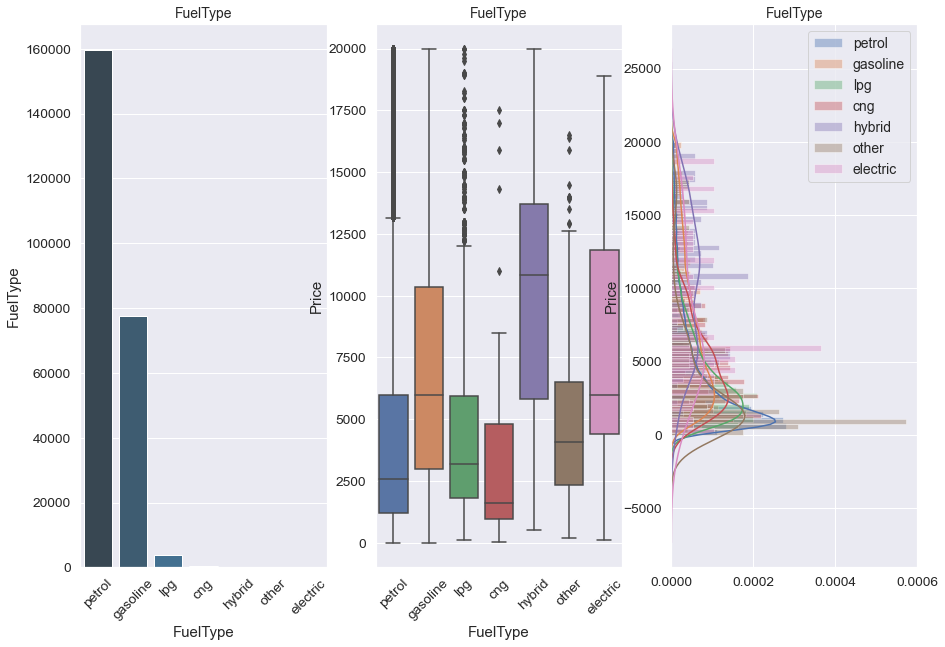

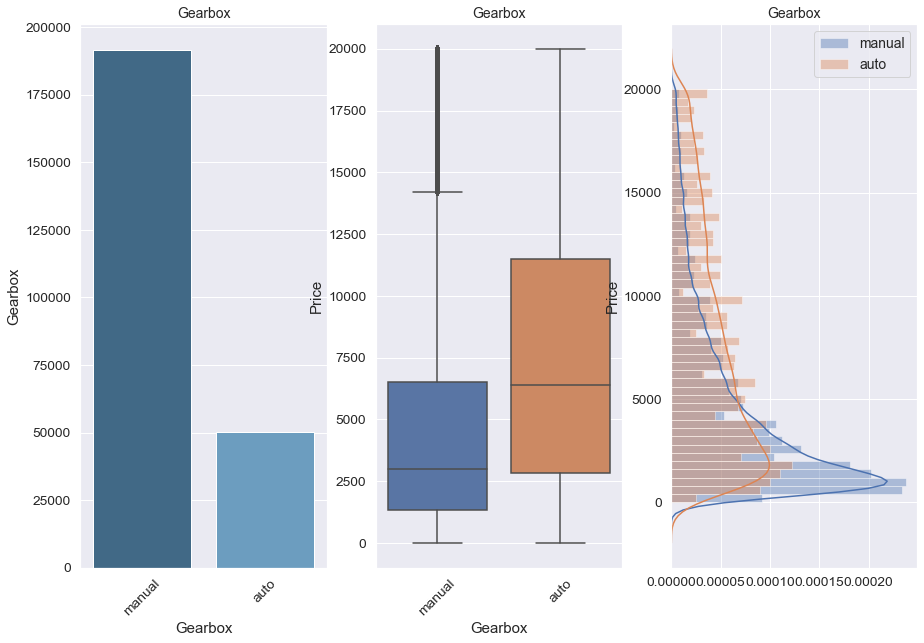

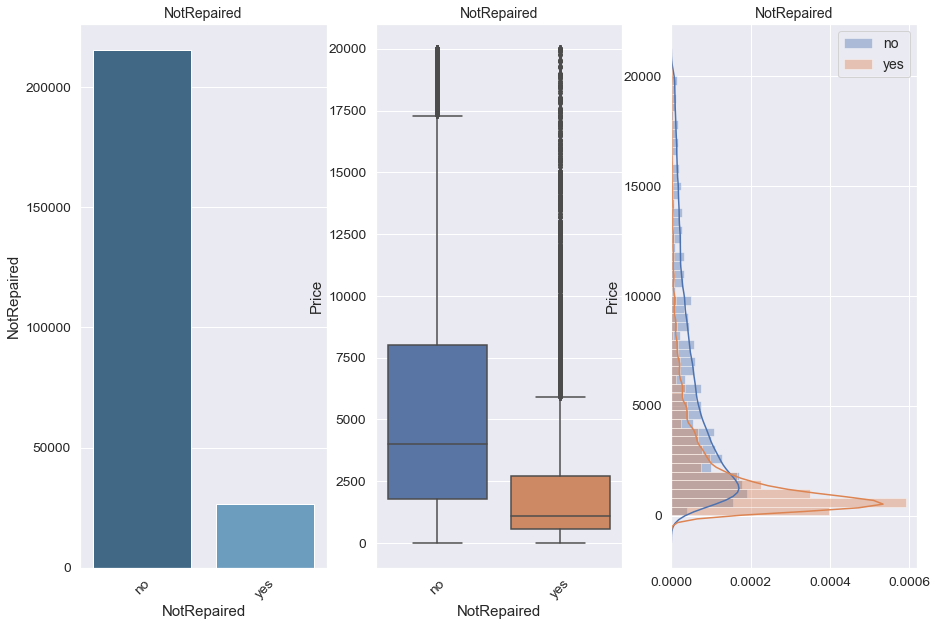

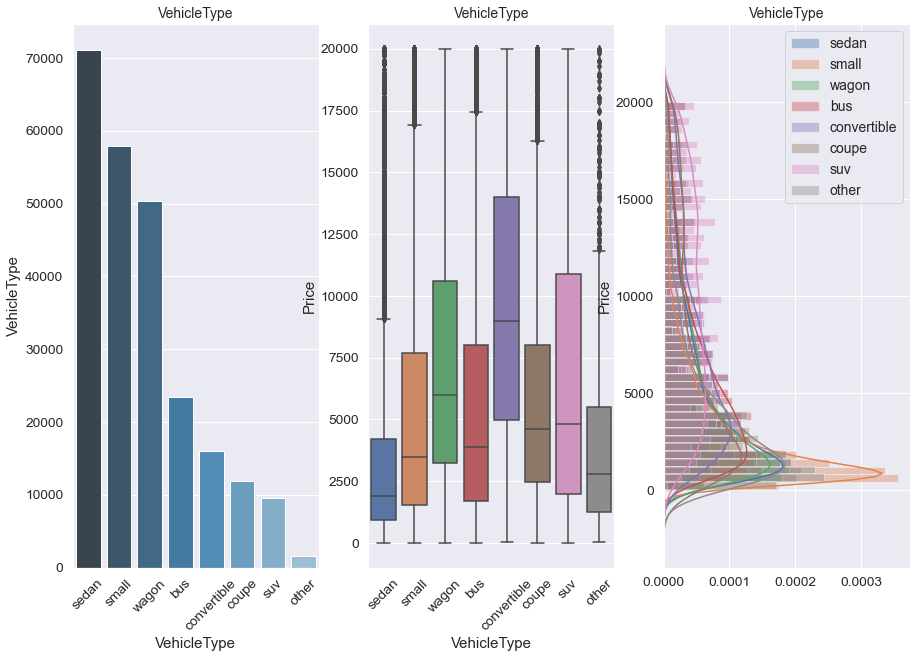

In [55]:
class_balance_threshold = 3

imbalance_features = []

for item in features_one_hot:
    if item != 'Model_Name':
        imbalance = one_hot_variable_analysis(data, item, target_name, 
                                              n_bins=50, class_balance_threshold=class_balance_threshold)
        if imbalance > class_balance_threshold:
            imbalance_features.append(item)
        
imbalance_features.append({'class_balance_threshold': class_balance_threshold})

petrol      159703
gasoline     77672
lpg           3836
cng            447
hybrid         178
other           65
electric        51
Name: FuelType, dtype: int64

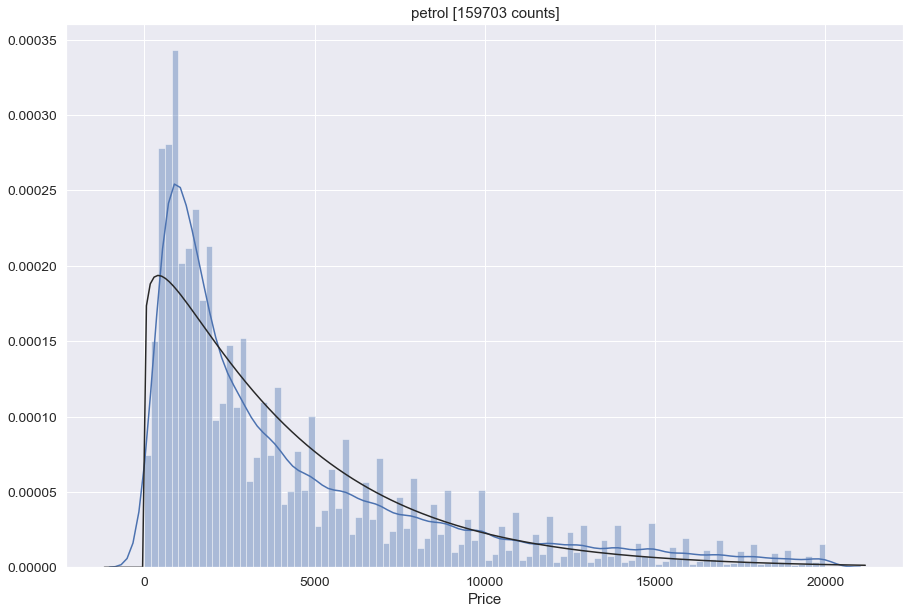

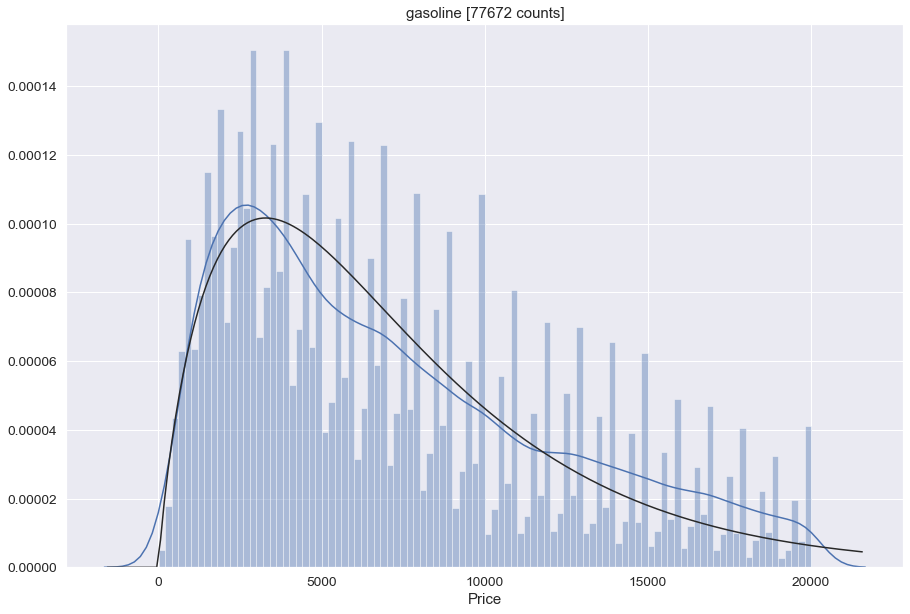

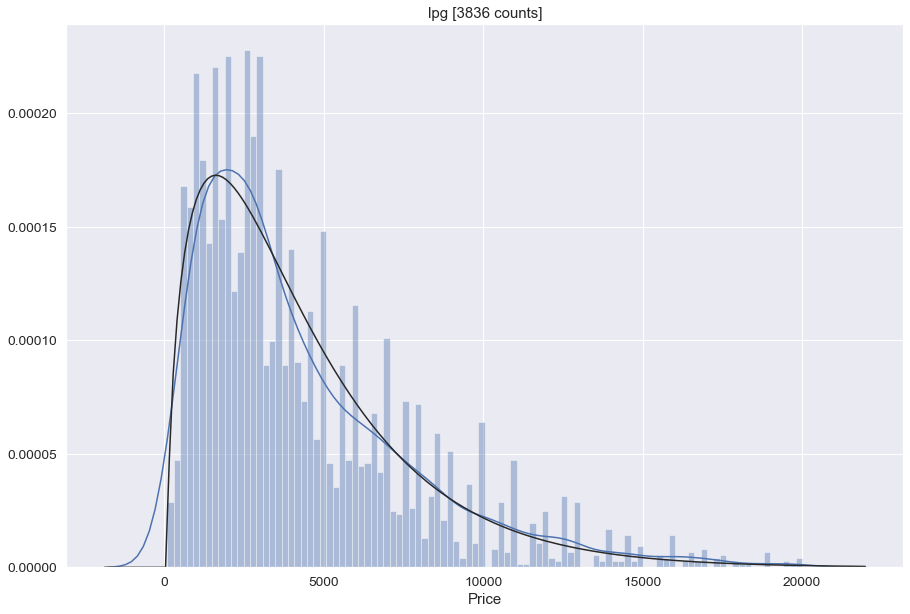

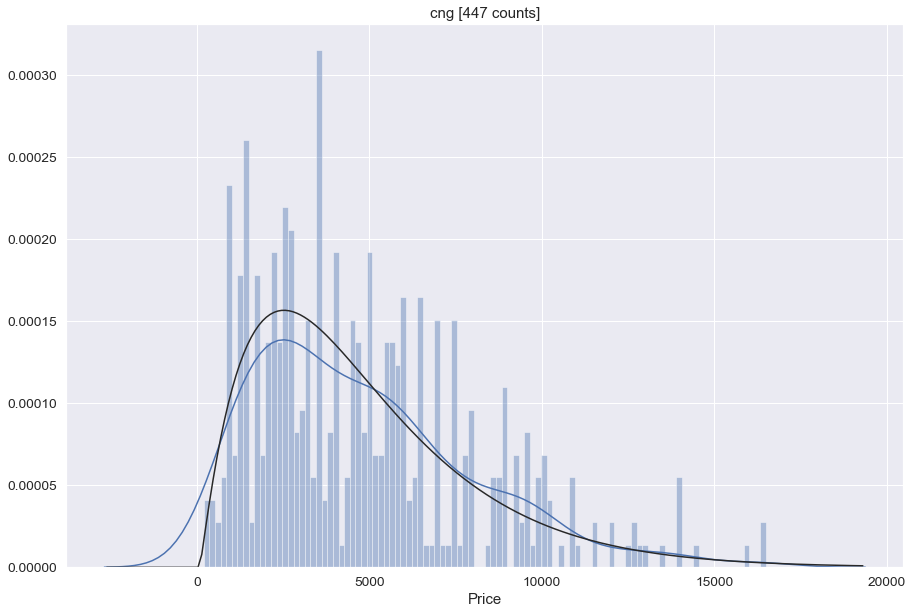

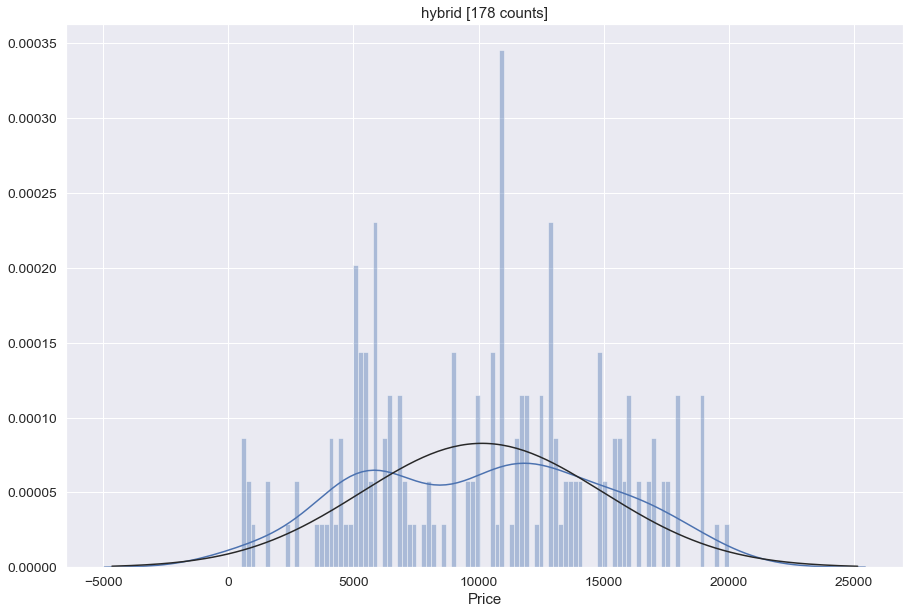

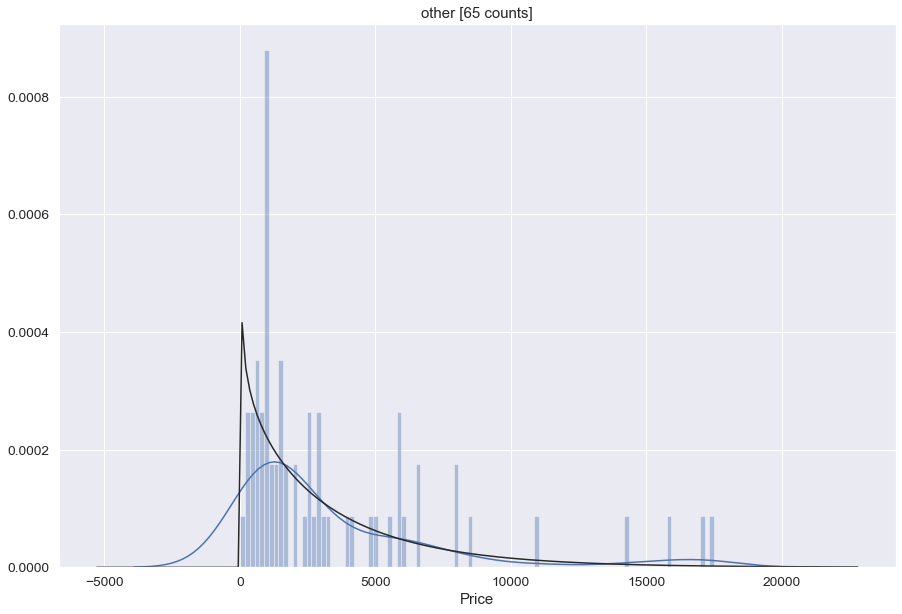

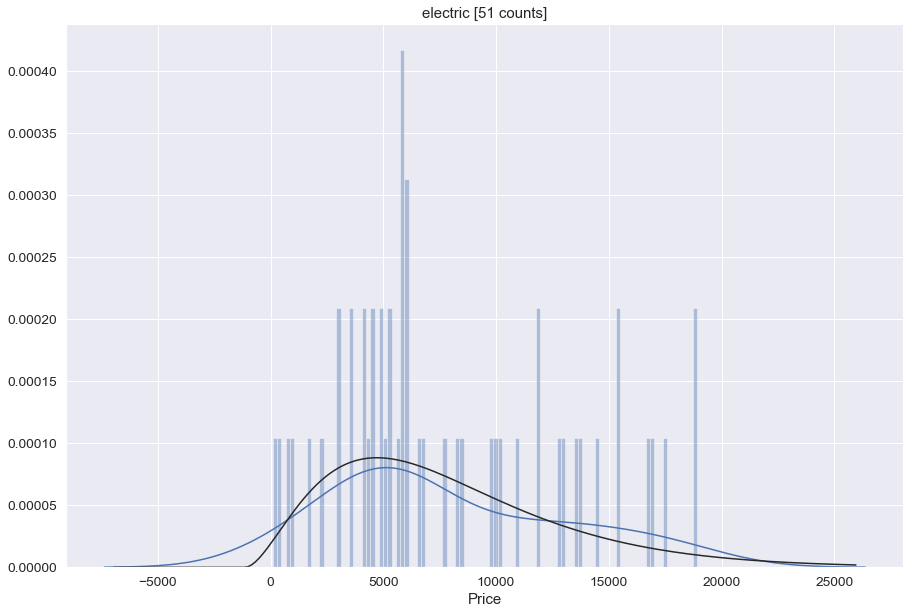

In [56]:
df = data
item = 'FuelType'

value_distr = df[item].value_counts()

for value in value_distr.index:
    fig, axes = plt.subplots(1, 1, figsize=(15, 10))
    sns.distplot(df[ df[item] == value ][target_name], bins=100, label=value, fit=gamma)
    axes.set_title("{} [{} counts]".format( value, value_distr[value] ))

value_distr

Распределения для всех признаков выглядят адекватно и все более-менее адекватно сходи с $\Gamma$_распределением. Выбросов/аномалий не обнаружено. Еcть признаки с дисбалансом классов - стоит учесть при построении модели.

In [57]:
print("Есть признаки с существенным дисбалансом классов:", imbalance_features[:-1])
print("Порог дисбаланса (отношение частнотностей классов) =", imbalance_features[-1]['class_balance_threshold'])


Есть признаки с существенным дисбалансом классов: ['FuelType', 'Gearbox', 'NotRepaired', 'VehicleType']
Порог дисбаланса (отношение частнотностей классов) = 3


Из графиков видно, что признаков с одинаковым распределением целевого признака для разных классов - нет. Нет и нужды на статистические тесты.

## 1.7 Корреляционная матрица

Корреляционная матрица может помочь выявить либо сильную связь величин, либо заподозрить отсутствия взаимосвязи между величинами.

In [58]:
corr_matrix = data.corr()
corr_matrix

Price     Power  Kilometer  RegistrationDate
Price             1.000000  0.494948  -0.402223          0.556759
Power             0.494948  1.000000   0.094960          0.172758
Kilometer        -0.402223  0.094960   1.000000         -0.357594
RegistrationDate  0.556759  0.172758  -0.357594          1.000000

(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text major ticklabel objects>)

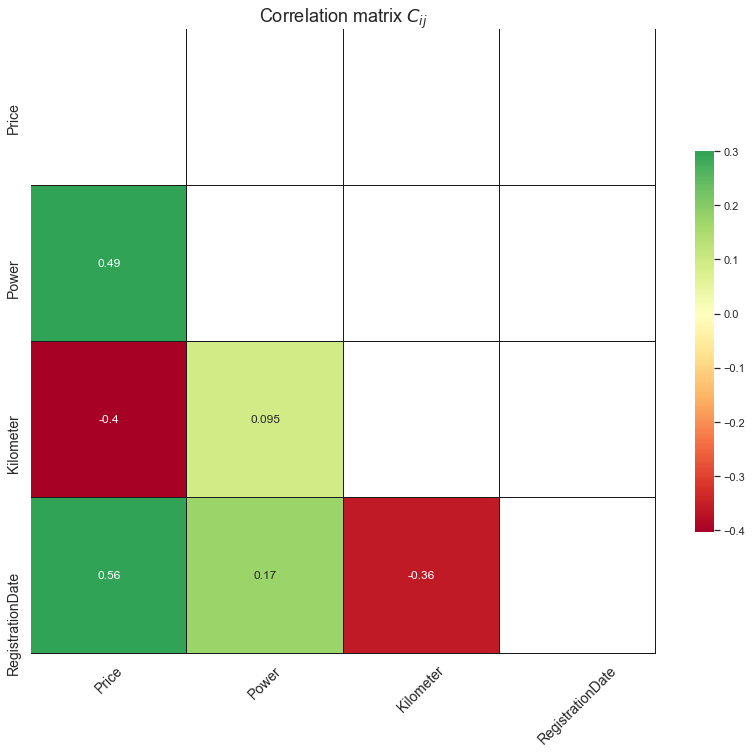

In [59]:
sns.set(style='whitegrid', palette="RdBu_r")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(14, 14))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(240, 10, as_cmap=True)
# cmap = sns.diverging_palette(150, 275, s=80, l=55, as_cmap=True)
cmap = sns.color_palette("RdYlGn", 200)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, vmax=.3, center=0, cmap=cmap, 
            annot=True, square=True, linewidths=0.1, linecolor='k', cbar_kws={"shrink": .5})

ax.set_title("Correlation matrix $C_{ij}$", fontsize=FONT_SIZE+4)
plt.xticks(rotation=45,  fontsize=FONT_SIZE) 
plt.yticks(fontsize=FONT_SIZE) 

Все коэффициенты корреляции вполне объяснимы:
    
| Признак-признак | $C_{ij}$ | Объяснение |
| :-- | --: | :-- |
| Power-Price | 0.49 | Больше мощность - больше цена |
| Kilometer-Price | -0.40 | Больше пробег - меньше цена |
| RegistrationDate-Price | 0.56 | Больше мощность - больше цена |
| Kilometer-Power | 0.095 | Слабосвязаны, но в принципе: что мощнее - бегает дальше |
| RegistrationDate-Power | 0.17 | Тоже не очень сильно связаны, но в принципе: Новее машина - больше мощность |
| RegistrationDate-Power | -0.36 | Новее машина - меньше пробег |

Для наглядности расположим признаки по убыванию коэффициента линейной корреляции с целевым признаком. Это покажет степень *линейного* влияния переменной (для которой можно вообще вычислить коэффициент линейной корреляции Пирсона) на целевой признак.

In [60]:
abs(corr_matrix[target_name]).sort_values(ascending=False)[1:]

RegistrationDate    0.556759
Power               0.494948
Kilometer           0.402223
Name: Price, dtype: float64

Полноты ради построим `pairplot`, хотя в нашем случае (обилие категориальных переменных, плюс `scatterplot` для численных переменных уже построены) это вряд и даст дополнительную информацию. Обычно польза от подобного сорта графиков бывает для численных (*непрерывных*) переменных. Но чем чёрт не шутит...




 The plotting of pairplot took 3.174 sec.

Wall time: 3.17 s


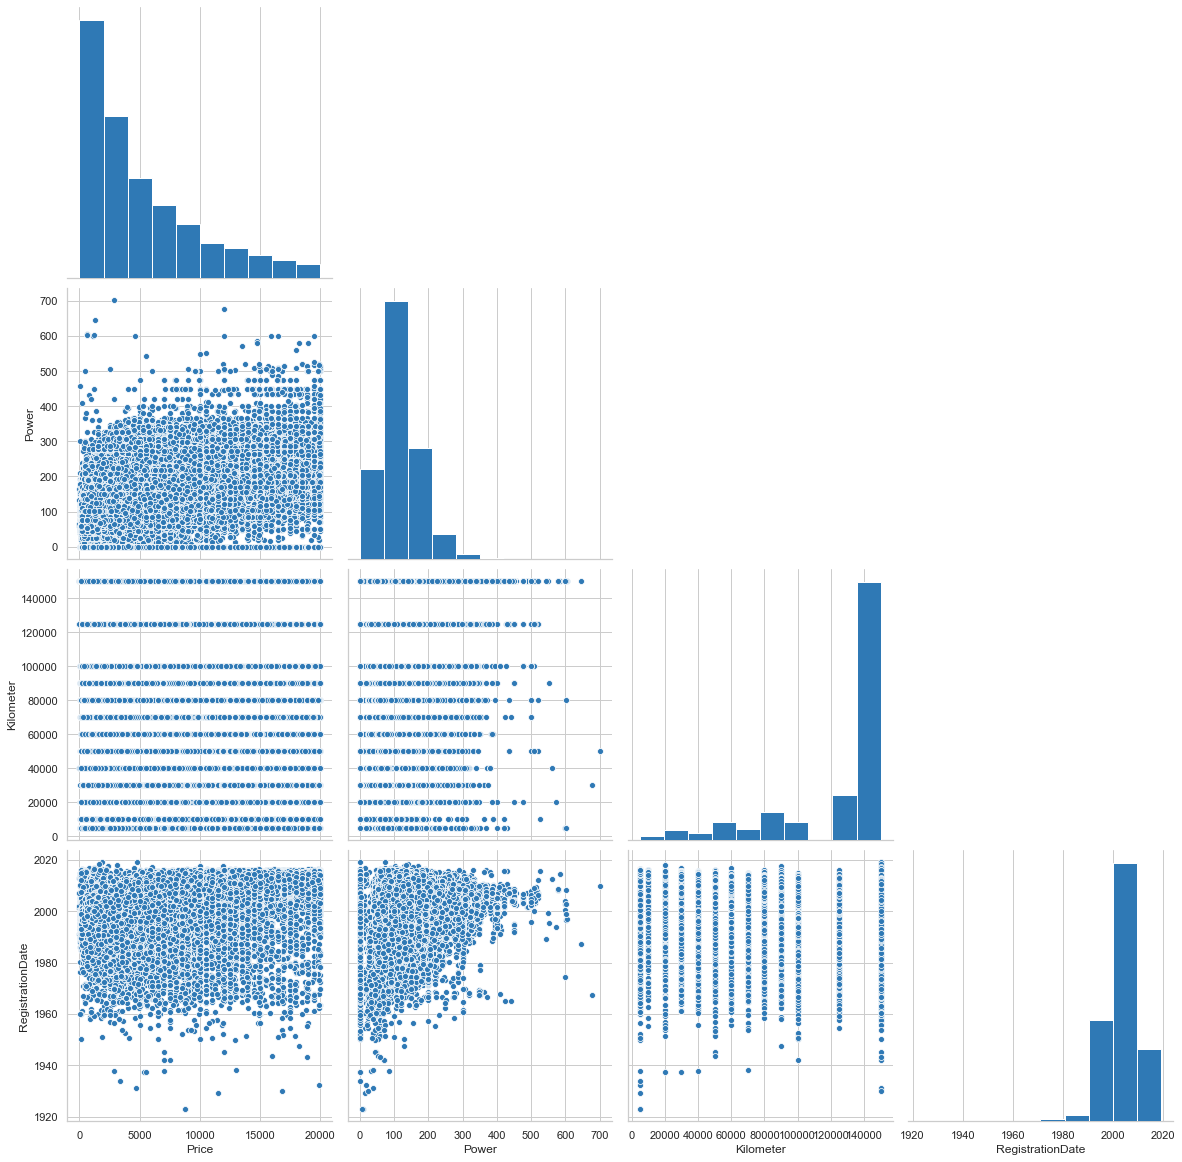

In [61]:
%%time

t_pairplot_start = time.time()
sns.pairplot(data, corner=True, height=4)
t_pairplot = time.time() - t_pairplot_start
print("\n"*3, "The plotting of pairplot took {:.3f} sec.\n".format(t_pairplot))

Новой информации нет. Всё уже найдено перед этим.

<div style="border:solid magenta 2px; padding: 20px"> <h1 style="color:magenta; margin-bottom:20px">Комментарии</h1>
    
<span style="color:magenta"> *Спасибо, Николай за пп. 1, 2 и 4!*
</span>
    
1. Наряду с силой связи, есть ещё характертеристика уровня значимости. Т.е. на сколько выявленной связи можно доверять (это теория р-уровня значений.
2. Данные имеют склонность быть нормальными и ненормальными. Этот факт важен при использовании расчётов коэффициента корреляции:
    - Если данные нормальные - используют критерий Пирсона
    - Если ненормальные - критерий Спирмена
3. И ещё: корреляция - очень подвержена выбросам! Если в данных они есть - вывод буде ложны.
4. Также очень важно соблюдать однородность выборки. Если пропустить этот момент, то вывод может быть ложным
5. Возможно, что зависимость нелинейна.

## 1.8 Преобразование данных

### 1.8.1 Преобразование типа данных

In [62]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241952 entries, 3 to 354367
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             241952 non-null  int64  
 1   VehicleType       241952 non-null  object 
 2   Gearbox           241952 non-null  object 
 3   Power             241952 non-null  int64  
 4   Kilometer         241952 non-null  int64  
 5   FuelType          241952 non-null  object 
 6   NotRepaired       241952 non-null  object 
 7   RegistrationDate  241952 non-null  float64
 8   Model_Name        241952 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 93.4 MB


In [63]:
for item in ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired', 'Model_Name']:
    data[item] = data[item].astype('category')
    
    
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241952 entries, 3 to 354367
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Price             241952 non-null  int64   
 1   VehicleType       241952 non-null  category
 2   Gearbox           241952 non-null  category
 3   Power             241952 non-null  int64   
 4   Kilometer         241952 non-null  int64   
 5   FuelType          241952 non-null  category
 6   NotRepaired       241952 non-null  category
 7   RegistrationDate  241952 non-null  float64 
 8   Model_Name        241952 non-null  category
dtypes: category(5), float64(1), int64(3)
memory usage: 20.6 MB


Преобразовали нечисловые и невременнЫе данные в тип `category`, облегчив вес таблицы в памяти в 4.5 раза (на 70 MB).

### 1.8.2 Преобразование *One-Hot* переменных

*One-Hot* переменные преобразуем в *dummy*-переменные, откинув одну *dummy*-переменную во избежании *dummy*-ловушки.

In [64]:
data_model = pd.get_dummies(data, columns=features_one_hot, drop_first=True).copy()
data_model.columns

Index(['Price', 'Power', 'Kilometer', 'RegistrationDate', 'FuelType_electric',
       'FuelType_gasoline', 'FuelType_hybrid', 'FuelType_lpg',
       'FuelType_other', 'FuelType_petrol',
       ...
       'Model_Name_volvo-xc_reihe', 'Gearbox_manual', 'NotRepaired_yes',
       'VehicleType_convertible', 'VehicleType_coupe', 'VehicleType_other',
       'VehicleType_sedan', 'VehicleType_small', 'VehicleType_suv',
       'VehicleType_wagon'],
      dtype='object', length=314)

In [65]:
data_model.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241952 entries, 3 to 354367
Columns: 314 entries, Price to VehicleType_wagon
dtypes: float64(1), int64(3), uint8(310)
memory usage: 80.8 MB


### 1.8.3 Преобразование *Ordinal* переменных

In [66]:
print(features_ordinal)

['Kilometer']


In [67]:
ord_encoder = OrdinalEncoder()

data_ordinal = pd.DataFrame(ord_encoder.fit_transform(data_model[features_ordinal]), 
                            columns=data_model[features_ordinal].columns, index=data_model.index)
Kilometer_code_book = dict(zip( range(0, len(ord_encoder.categories_[0])), ord_encoder.categories_[0] ))
print("Kilometer_code_book is", Kilometer_code_book)

# data_model['Kilometer'] = data_ordinal['Kilometer'].astype('int')
# data_model['Kilometer']

Kilometer_code_book is {0: 5000, 1: 10000, 2: 20000, 3: 30000, 4: 40000, 5: 50000, 6: 60000, 7: 70000, 8: 80000, 9: 90000, 10: 100000, 11: 125000, 12: 150000}


<div style="border:solid magenta 2px; padding: 20px"> <h1 style="color:magenta; margin-bottom:20px">Вопрос</h1>

**И вот интереснейший вопрос: как масштабировать порядковые признаки?**

Текущий ответ, полученный комбинацией методов "палец-потолок" и "от противного" - MinMax. Но на самом-то деле?

В голову приходит что-то о частотности (може Флахом навеянное), но как конкретно...?

<div style="border:solid blue 2px; padding: 20px"> <h1 style="color:blue; margin-bottom:20px">КОММЕНТАРИЙ РЕВЬЮЕРА</h1>

    
хороший вопрос))<br>
от мин-макс - нормальный подход.<br>
(например, такая формула как здесь: https://megaobuchalka.ru/9/5906.html

Другой ворпос: а всегда шкалирование порядковых шкал нужно?<br>
Чаще всего это упорядоченные значения от 0 до 20 (максимум). Теоретически, можно приводить к диапазону (0,1).<br>
Надо конечно смотреть на задачу.<br>
    
Может перевести их в бинарные, будет где-то и лучше всего.<br>
(Мне такой подход больше нравится.)

In [68]:
minmax_scaler = MinMaxScaler()
data_scaled = minmax_scaler.fit_transform(data_ordinal)
data_model['Kilometer'] = data_scaled

### 1.8.4 Масштабирование численных переменных

==== Power ====
          count        mean        std  min   25%    50%    75%    max
Power  241952.0  118.349764  57.684642  0.0  75.0  111.0  150.0  702.0 

Pearson correlation coefficient of 'Power' and 'Price' is 0.4949. 

There are 0 missing values in 'Power'. 


==== RegistrationDate ====
                     count         mean       std     min      25%      50%  \
RegistrationDate  241952.0  2003.495273  6.147546  1923.0  1999.75  2003.92   

                      75%     max  
RegistrationDate  2007.83  2019.0   

Pearson correlation coefficient of 'RegistrationDate' and 'Price' is 0.5568. 

There are 0 missing values in 'RegistrationDate'. 




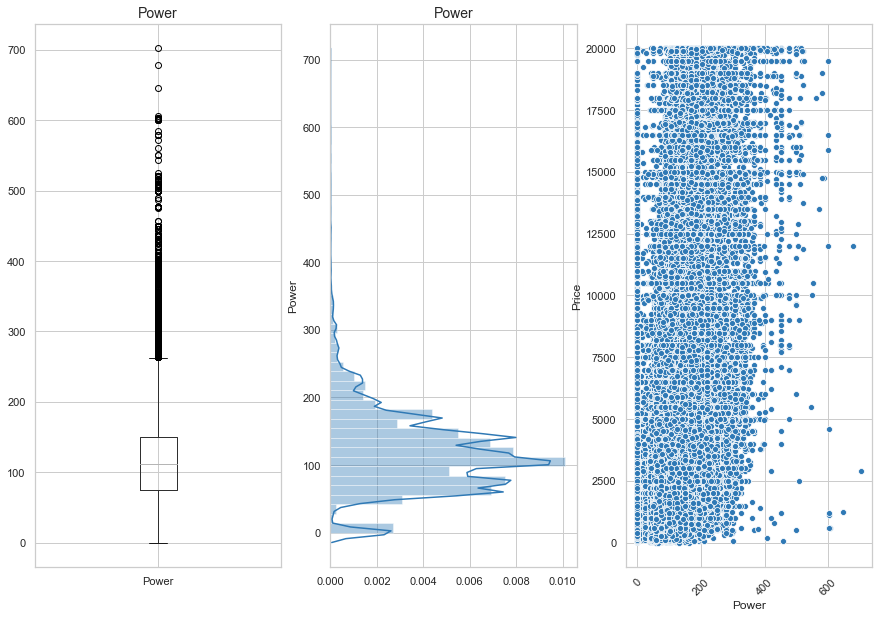

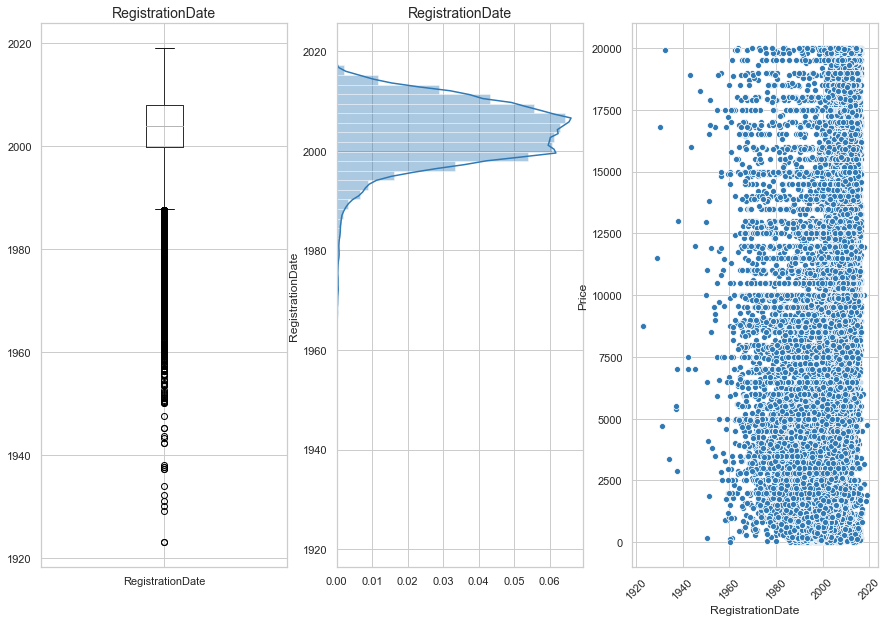

In [69]:
for item in features_numerical:
    num_variable_analysis(data_model, item, target_name, n_bins=50)

Распределения признаков подсказывают выбрать стандартное масштабирование.

In [70]:
stand_scaler = StandardScaler()
stand_scaler.fit(data_model[features_numerical])
data_scaled = pd.DataFrame(stand_scaler.transform(data_model[features_numerical]), 
                          columns=data_model[features_numerical].columns, index=data_model.index, )
data_model[features_numerical] = data_scaled[features_numerical]
data_model

Price     Power  Kilometer  RegistrationDate  FuelType_electric  \
3        1500 -0.751497   1.000000         -0.324565                  0   
4        3600 -0.855511   0.750000          0.827117                  0   
5         650 -0.283434   1.000000         -1.246886                  0   
6        2200 -0.162084   1.000000          0.191089                  0   
10       2000 -0.231427   1.000000          0.244769                  0   
...       ...       ...        ...               ...                ...   
354360   3999 -1.999666   1.000000          0.313089                  0   
354362   3200  1.848854   1.000000          0.150422                  0   
354363   1150 -2.051673   1.000000         -0.527898                  0   
354366   1199 -0.300770   0.916667         -0.527898                  0   
354367   9200 -0.283434   1.000000         -1.178566                  0   

        FuelType_gasoline  FuelType_hybrid  FuelType_lpg  FuelType_other  \
3                       0                0             0               0   
4                       1                0             0               0   
5                       0                0             0               0   
6                       0                0             0               0   
10                      0                0             0               0   
...                   ...              ...           ...             ...   
354360                  1                0             0               0   
354362                  0                0             0               0   
354363                  0                0             0               0   
354366                  0                0             0               0   
354367                  1                0             0               0   

        FuelType_petrol  ...  Model_Name_volvo-xc_reihe  Gearbox_manual  \
3                     1  ...                          0               1   
4                     0  ...                          0               1   
5                     1  ...                          0               1   
6                     1  ...                          0               1   
10                    1  ...                          0               1   
...                 ...  ...                        ...             ...   
354360                0  ...                          0               1   
354362                1  ...                          0               1   
354363                1  ...                          0               1   
354366                1  ...                          0               0   
354367                0  ...                          0               1   

        NotRepaired_yes  VehicleType_convertible  VehicleType_coupe  \
3                     0                        0                  0   
4                     0                        0                  0   
5                     1                        0                  0   
6                     0                        1                  0   
10                    0                        0                  0   
...                 ...                      ...                ...   
354360                0                        0                  0   
354362                1                        0                  0   
354363                0                        0                  0   
354366                0                        1                  0   
354367                0                        0                  0   

        VehicleType_other  VehicleType_sedan  VehicleType_small  \
3                       0                  0                  1   
4                       0                  0                  1   
5                       0                  1                  0   
6                       0                  0                  0   
10                      0                  1                  0   
...                   ...             

## 1.99 Информация о данных:

В предоставленной таблице было 354368 записей (много), с 16 признаками. 

Было проведено:
- Удаление дубликатов (4).
- Удаление всех пропусков (данных много).
- Удаление аномальных записей со значениями:
    - цены в `0` и `1` евро,
    - мощности двигателя больше 750 л.с.
- Удаление признаков, ненужных для создания модели (8).
- Создание новых признаков (2).
- Преобразование типов данных /dtype/.
- Преобразование *One-Hot* переменных в *dummy*-переменные с избеганием *dummy*-ловушки.
- Преобразование *Ordinal* переменных с помощью `OrdinalEncoder()`. Кодирующий словарь `Kilometer_code_book` прилагается.
- Масштабирование численных признаков стандартным масштабированим.

В результате остался датасет с 241952 записями (достаточнодля построения модели) и 9 признаками (включая целевой):

| Признаки | Описание | dtype | Тип данных |
| :-- | :-- | :-- | :-- |
| *DateCrawled* | дата скачивания анкеты из базы | object -> datetime | **Не нужен** |
| **VehicleType** | тип автомобильного кузова | object -> category | *One-Hot*| 
| *RegistrationYear* | год регистрации автомобиля | int64 | **Объединить** с `RegistrationMonth` в один признак `RegistrationDate` (datetime) <br/> *Numerical* | 
| **Gearbox** | тип коробки передач | object -> category | *One-Hot* | 
| **Power** | мощность (л. с.) | int64 | *Numerical* | 
| *Model* | модель автомобиля | object -> category | **Объединить** с `Brand` в один признак `Model_Name` (category) <br/> *One-Hot* | 
| **Kilometer** | пробег (км) | int64 | *Ordinal* | 
| *RegistrationMonth* | месяц регистрации автомобиля | int64 -> datetime | **Объединить** с `RegistrationYear` в один признак `RegistrationDate` (datetime) |
| **FuelType** | тип топлива | object -> category | *One-Hot* | 
| *Brand* | марка автомобиля | object -> category | **Объединить** с `Model` в один признак `Model_Name` (category) <br/> *One-Hot* | 
| **NotRepaired** | была машина в ремонте или нет | object -> category | *One-Hot* | 
| *DateCreated* | дата создания анкеты | object -> category | **Не нужен** | 
| *NumberOfPictures* | количество фотографий автомобиля | int64 | **Не нужен** |
| *PostalCode* | почтовый индекс владельца анкеты (пользователя) | int64 | **Не нужен** |
| *LastSeen* | дата последней активности пользователя | object -> datetime | **Не нужен** |
| | **Сгенерированные признаки** | | | 
| **RegistrationDate**  | Время регистрации автомобиля с точностью до месяца | datetime -> float | *Numerical* | 
| **Model_Name** | Модль с указанием производителя | category | *One-Hot* | 
| | **Целевой признак** | | | 
| **Price** | цена (евро) | int64 | | 

Жирным выделены **признаки, сохранённые для создания модели**.

Еcть признаки с дисбалансом классов - стоит учесть при построении модели.

# 2. Обучение моделей

Обучим различные модели:
- Линейная регрессия (с "ручным" бэггингом)
- Решающее дерево (с "ручным" бэггингом)
- Случайный лес (с "ручным" бэггингом)
- CatBoostRegressor 
- LightGBM



*Бэггинг - частный вид усреднения модели. Здесь будем выбирать данные равномерно и безвозвратно, благо данных много.*

In [71]:
target = data_model['Price']
# target_log = np.log10( data_model['Price'] )
features = data_model.drop(['Price'], axis=1)

Учитывая, что для обучения моделей у нас около четверти миллиона записи (много) определим в тестовой набор порядка тысячи записей (через константу `batch_test`), а для *обучающего батча* будем брать в три раза больше из того, что осталось.

In [72]:
batch_test = 3000

In [73]:
features_storage, features_test, target_storage, target_test = train_test_split(features, target, 
                                                                            test_size=batch_test,
                                                                            random_state=RANDOM_STATE)

features_storage, features_valid, target_storage, target_valid = train_test_split(features_storage, target_storage, 
                                                                            test_size=batch_test,
                                                                            random_state=RANDOM_STATE)

print( len(target_storage), len(target_valid), len(target_test) )

235952 3000 3000


In [74]:
epoch = int(len(features_storage)/(3*batch_test))

batch_test = int(len(features_storage)/(3*epoch))
print(batch_test, epoch)

3025 26


## 2.1 Линейная регрессия

    ### Just bagging

In [75]:
%%time

predictions = []
rmses_lin = []

features_depot = features_storage.copy()

for k in range(epoch):
    if k != epoch-1:
        # take a batch
        features_train = features_depot.sample(3*batch_test)
        features_depot = features_depot.drop(index=features_train.index)        
    else:
        features_train = features_depot
    target_train = target_storage.loc[features_train.index]
        
    model = LinearRegression()
    model.fit(features_train, target_train)
    pred = model.predict(features_valid)
    
    rmse = mse(target_valid, pred, squared=False)
    rmses_lin.append(rmse)
    predictions.append(pred)
    
    print("k={}: train size={}, storage size={}. RMSE={:.2f}".format(k, len(target_train), len(features_depot), rmse))
    
prediction = np.array(predictions).mean(axis=0)
rmse_lin_valid = mse(target_valid, prediction, squared=False)
rmse_lin_test = mse(target_test, prediction, squared=False)

k=0: train size=9075, storage size=226877. RMSE=46491100889905.52
k=1: train size=9075, storage size=217802. RMSE=75541.06
k=2: train size=9075, storage size=208727. RMSE=4377.09
k=3: train size=9075, storage size=199652. RMSE=2714.83
k=4: train size=9075, storage size=190577. RMSE=3261991242353.30
k=5: train size=9075, storage size=181502. RMSE=135365577068514.75
k=6: train size=9075, storage size=172427. RMSE=114843594032526.36
k=7: train size=9075, storage size=163352. RMSE=7500479522393.67
k=8: train size=9075, storage size=154277. RMSE=124978563947275.67
k=9: train size=9075, storage size=145202. RMSE=2709.05
k=10: train size=9075, storage size=136127. RMSE=18290029502132.63
k=11: train size=9075, storage size=127052. RMSE=113292012533520.94
k=12: train size=9075, storage size=117977. RMSE=181494202708036.12
k=13: train size=9075, storage size=108902. RMSE=112019338239082.70
k=14: train size=9075, storage size=99827. RMSE=655507701655.57
k=15: train size=9075, storage size=90752. 

In [76]:
print("Minimal over batches                          RMSE = {:.2f}\n".format(min(rmses_lin)))
print("Prediction is the mean of predictions (valid) RMSE = {:.2f}\n".format(rmse_lin_valid))
print("Prediction is the mean of predictions (test)  RMSE = {:.2f}\n".format(rmse_lin_test))

fitting = (rmse_lin_test-rmse_lin_valid)/rmse_lin_test
fitting_threshold = 0.3


if fitting > fitting_threshold:
    print("Model is OVERfitted: (RMSE_test - RMSE_valid)/RMSE_test = {}\n".format(fitting))
elif fitting < -fitting_threshold:
    print("Model is UNDERfitted: (RMSE_test - RMSE_valid)/RMSE_test = {}\n".format(fitting))
else:
    print("(RMSE_test - RMSE_valid)/RMSE_test = {}\n".format(fitting))

Minimal over batches                          RMSE = 2706.22

Prediction is the mean of predictions (valid) RMSE = 18881773460070.35

Prediction is the mean of predictions (test)  RMSE = 18881773460130.15

(RMSE_test - RMSE_valid)/RMSE_test = 3.167116763490065e-12



In [77]:
print(prediction.min(), prediction.max())

-171072048881916.03 851034561701779.8


Линейная регрессия показала свою непригодность, что и неудивительно. Ведь зависимость цены от, например даты выпуска, явно нелинейна - она точно не пересечёт ноль и не станет отрицательной. Хотя для отдельных батчей (примерно четверти) модели удавалось получтить RMSE в несколько тысяч.

**Вывод**: Линейная регрессия непригодна, в силу нелинейной зависимости целевого признака от переменных. Соответственно и метод бэггинга для линейной регрессии не работает.

<div style="border:solid blue 2px; padding: 20px"> <h1 style="color:blue; margin-bottom:20px">КОММЕНТАРИЙ РЕВЬЮЕРА</h1>
<font color='green'>
разброс точно большой)) а с чем сравнивали?
</b></font>

Со среднеквадратичным отклонением цены.

## 2.2 Решающее дерево

    ### Just bagging

In [78]:
%%time

predictions = []
rmses_tree = []

features_depot = features_storage.copy()

for k in range(epoch):
    if k != epoch-1:
        # take a batch
        features_train = features_depot.sample(3*batch_test)
        features_depot = features_depot.drop(index=features_train.index)        
    else:
        features_train = features_depot
    target_train = target_storage.loc[features_train.index]
        
    model = DecisionTreeRegressor()
    model.fit(features_train, target_train)
    pred = model.predict(features_valid)
    
    rmse = mse(target_valid, pred, squared=False)
    rmses_tree.append(rmse)
    predictions.append(pred)
    
    print("k={}: train size={}, storage size={}. RMSE={:.2f}".format(k, len(target_train), len(features_depot), rmse))
    
prediction = np.array(predictions).mean(axis=0)
rmse_tree_valid = mse(target_valid, prediction, squared=False)
rmse_tree_test = mse(target_test, prediction, squared=False)

k=0: train size=9075, storage size=226877. RMSE=2634.82
k=1: train size=9075, storage size=217802. RMSE=2654.63
k=2: train size=9075, storage size=208727. RMSE=2511.40
k=3: train size=9075, storage size=199652. RMSE=2598.84
k=4: train size=9075, storage size=190577. RMSE=2492.64
k=5: train size=9075, storage size=181502. RMSE=2551.53
k=6: train size=9075, storage size=172427. RMSE=2491.45
k=7: train size=9075, storage size=163352. RMSE=2536.73
k=8: train size=9075, storage size=154277. RMSE=2422.72
k=9: train size=9075, storage size=145202. RMSE=2445.41
k=10: train size=9075, storage size=136127. RMSE=2509.14
k=11: train size=9075, storage size=127052. RMSE=2662.22
k=12: train size=9075, storage size=117977. RMSE=2482.41
k=13: train size=9075, storage size=108902. RMSE=2412.33
k=14: train size=9075, storage size=99827. RMSE=2581.33
k=15: train size=9075, storage size=90752. RMSE=2547.25
k=16: train size=9075, storage size=81677. RMSE=2516.52
k=17: train size=9075, storage size=72602. R

In [79]:
print("Minimal over batches                          RMSE = {:.2f}\n".format(min(rmses_tree)))
print("Prediction is the mean of predictions (valid) RMSE = {:.2f}\n".format(rmse_tree_valid))
print("Prediction is the mean of predictions (test)  RMSE = {:.2f}\n".format(rmse_tree_test))

fitting = (rmse_tree_test-rmse_tree_valid)/rmse_tree_test
fitting_threshold = 0.3


if fitting > fitting_threshold:
    print("Model is OVERfitted: (RMSE_test - RMSE_valid)/RMSE_test = {}\n".format(fitting))
elif fitting < -fitting_threshold:
    print("Model is UNDERfitted: (RMSE_test - RMSE_valid)/RMSE_test = {}\n".format(fitting))
else:
    print("(RMSE_test - RMSE_valid)/RMSE_test = {}\n".format(fitting))

Minimal over batches                          RMSE = 2412.33

Prediction is the mean of predictions (valid) RMSE = 1766.71

Prediction is the mean of predictions (test)  RMSE = 6350.43

Model is OVERfitted: (RMSE_test - RMSE_valid)/RMSE_test = 0.7217963707083046



У решающего дерева ситуация получше. RMSE лежит в пределах тысяч евро, а не тысяч миллиардов как у линейной регрессии. 

RMSE, вычисленное по усреднённому предсказанию, лучше на треть, чем минимальное RMSE "лучшего" батча, т.е., бэггинг работает.

Сравнение RMSE для тестовой выборки и валидационной показывает, что модель переобучилась.

Можно улучшить предсказание подбирая параметры (например, глубину дерева).

## 2.3 Случайный лес

    ### Just bagging

In [80]:
%%time

predictions = []
rmses_forest = []

features_depot = features_storage.copy()

for k in range(epoch):
    if k != epoch-1:
        # take a batch
        features_train = features_depot.sample(3*batch_test)
        features_depot = features_depot.drop(index=features_train.index)        
    else:
        features_train = features_depot
    target_train = target_storage.loc[features_train.index]
        
    model = RandomForestRegressor()
    model.fit(features_train, target_train)
    pred = model.predict(features_valid)
    
    rmse = mse(target_valid, pred, squared=False)
    rmses_forest.append(rmse)
    predictions.append(pred)
    
    print("k={}: train size={}, storage size={}. RMSE={:.2f}".format(k, len(target_train), len(features_depot), rmse))
    
prediction = np.array(predictions).mean(axis=0)
rmse_forest_valid = mse(target_valid, prediction, squared=False)
rmse_forest_test = mse(target_test, prediction, squared=False)

k=0: train size=9075, storage size=226877. RMSE=1968.87
k=1: train size=9075, storage size=217802. RMSE=1926.92
k=2: train size=9075, storage size=208727. RMSE=1963.44
k=3: train size=9075, storage size=199652. RMSE=1971.84
k=4: train size=9075, storage size=190577. RMSE=1968.58
k=5: train size=9075, storage size=181502. RMSE=1954.73
k=6: train size=9075, storage size=172427. RMSE=1967.04
k=7: train size=9075, storage size=163352. RMSE=1973.11
k=8: train size=9075, storage size=154277. RMSE=1923.52
k=9: train size=9075, storage size=145202. RMSE=1930.48
k=10: train size=9075, storage size=136127. RMSE=1935.19
k=11: train size=9075, storage size=127052. RMSE=1934.47
k=12: train size=9075, storage size=117977. RMSE=1950.86
k=13: train size=9075, storage size=108902. RMSE=1940.03
k=14: train size=9075, storage size=99827. RMSE=1922.20
k=15: train size=9075, storage size=90752. RMSE=1969.77
k=16: train size=9075, storage size=81677. RMSE=1913.78
k=17: train size=9075, storage size=72602. R

In [81]:
print("Minimal over batches                          RMSE = {:.2f}\n".format(min(rmses_forest)))
print("Prediction is the mean of predictions (valid) RMSE = {:.2f}\n".format(rmse_forest_valid))
print("Prediction is the mean of predictions (test)  RMSE = {:.2f}\n".format(rmse_forest_test))

fitting = (rmse_forest_test-rmse_forest_valid)/rmse_forest_test
fitting_threshold = 0.3


if fitting > fitting_threshold:
    print("Model is OVERfitted: (RMSE_test - RMSE_valid)/RMSE_test = {}\n".format(fitting))
elif fitting < -fitting_threshold:
    print("Model is UNDERfitted: (RMSE_test - RMSE_valid)/RMSE_test = {}\n".format(fitting))
else:
    print("(RMSE_test - RMSE_valid)/RMSE_test = {}\n".format(fitting))

Minimal over batches                          RMSE = 1913.78

Prediction is the mean of predictions (valid) RMSE = 1783.47

Prediction is the mean of predictions (test)  RMSE = 6319.85

Model is OVERfitted: (RMSE_test - RMSE_valid)/RMSE_test = 0.7177982508787004



История практически такая же, как у решающего дерева, за исключением того, что бэггинг почти не работает, что и неудивительно, ведь случайный лес по сути своей выдаёт предсказание по ансамблю решающих деревьев. Числовые показатели схожи, затраченное время в 3.5 раза больше. Есть возможность улучшить предсказания подбором гиперпараметров модели.

## 2.4 CatBoostRegressor

Обучим `CatBoostRegressor`, у которой есть "встроенный" бустинг. Рассмотрим различные значения `learning_rate` и `depth`.


**Не понятно:**
- Можно ли что-то сделать с несбалансированностью классов уже внутри модели? Например "взвесить" классы? Или надо делать *downsampling* при подготовки данных?


**Важно:**

Если случится переобучение - уменьшать скорость обучения.

*/Tree depth: In most cases, the optimal depth ranges from 4 to 10. Values in the range from 6 to 10 are recommended./*

    CatBoostError: only one of the parameters iterations, n_estimators, num_boost_round, num_trees should be initialized.

### learning_rate=1

In [82]:
%%time

# # Sample from dataset
# train_features = features_storage.sample(3*batch_test)
# train_target = target_storage.loc[train_features.index]

# Whole dataset
train_features = features_storage
train_target = target_storage
    

n_iter = 1000
depthes = np.arange(4, 11)

rmses_catboo_test = {}
# learning_rate = [0.1, 1]

for depth in depthes:
    print("\nDepth =", depth)
    
    model = CatBoostRegressor(iterations=n_iter, learning_rate=1, depth=2, verbose=int(n_iter/10))
    model.fit(train_features, train_target)    
    prediction_catboo = model.predict(features_test)    
    rmse_catboo_test = mse(target_test, prediction_catboo, squared=False)
    rmses_catboo_test[depth] = rmse_catboo_test


Depth = 4
0:	learn: 3198.4546068	total: 80.3ms	remaining: 1m 20s
100:	learn: 1847.3915521	total: 2.02s	remaining: 17.9s
200:	learn: 1745.0504510	total: 3.94s	remaining: 15.7s
300:	learn: 1688.7444163	total: 5.97s	remaining: 13.9s
400:	learn: 1652.7612771	total: 7.75s	remaining: 11.6s
500:	learn: 1626.7732627	total: 9.33s	remaining: 9.29s
600:	learn: 1606.6947569	total: 11s	remaining: 7.28s
700:	learn: 1590.7348165	total: 12.6s	remaining: 5.39s
800:	learn: 1577.4962693	total: 14.3s	remaining: 3.55s
900:	learn: 1566.0792181	total: 16s	remaining: 1.76s
999:	learn: 1557.4524825	total: 17.7s	remaining: 0us

Depth = 5
0:	learn: 3198.4546068	total: 20.6ms	remaining: 20.6s
100:	learn: 1847.3915521	total: 1.74s	remaining: 15.5s
200:	learn: 1745.0504510	total: 3.44s	remaining: 13.7s
300:	learn: 1688.7444163	total: 5.11s	remaining: 11.9s
400:	learn: 1652.7612771	total: 6.8s	remaining: 10.2s
500:	learn: 1626.7732627	total: 8.47s	remaining: 8.44s
600:	learn: 1606.6947569	total: 10.2s	remaining: 6.

In [83]:
rmses_catboo_test

{4: 1772.1953745125165,
 5: 1772.1953745125165,
 6: 1772.1953745125165,
 7: 1772.1953745125165,
 8: 1772.1953745125165,
 9: 1772.1953745125165,
 10: 1772.1953745125165}

### learning_rate=0.1

In [84]:
%%time

# # Sample from dataset
# train_features = features_storage.sample(3*batch_test)
# train_target = target_storage.loc[train_features.index]

# Whole dataset
train_features = features_storage
train_target = target_storage
    

n_iter = 1000
depthes = np.arange(4, 11)

rmses_catboo_test = {}
# learning_rate = [0.1, 1]

for depth in depthes:
    print("\nDepth =", depth)
    
    model = CatBoostRegressor(iterations=n_iter, learning_rate=0.1, depth=2, verbose=int(n_iter/10))
    model.fit(train_features, train_target)    
    prediction_catboo = model.predict(features_test)    
    rmse_catboo_test = mse(target_test, prediction_catboo, squared=False)
    rmses_catboo_test[depth] = rmse_catboo_test


Depth = 4
0:	learn: 4462.8994234	total: 21.1ms	remaining: 21.1s
100:	learn: 2117.5135103	total: 1.98s	remaining: 17.6s
200:	learn: 2024.6465890	total: 3.98s	remaining: 15.8s
300:	learn: 1976.3491299	total: 5.95s	remaining: 13.8s
400:	learn: 1941.6245667	total: 7.9s	remaining: 11.8s
500:	learn: 1916.4335756	total: 9.88s	remaining: 9.84s
600:	learn: 1891.7309702	total: 11.8s	remaining: 7.86s
700:	learn: 1873.1256891	total: 13.8s	remaining: 5.89s
800:	learn: 1854.5458021	total: 15.8s	remaining: 3.91s
900:	learn: 1838.3698865	total: 17.7s	remaining: 1.95s
999:	learn: 1823.1431902	total: 19.6s	remaining: 0us

Depth = 5
0:	learn: 4462.8994234	total: 26.6ms	remaining: 26.5s
100:	learn: 2117.5135103	total: 2.08s	remaining: 18.5s
200:	learn: 2024.6465890	total: 4.34s	remaining: 17.3s
300:	learn: 1976.3491299	total: 6.33s	remaining: 14.7s
400:	learn: 1941.6245667	total: 8.28s	remaining: 12.4s
500:	learn: 1916.4335756	total: 10.2s	remaining: 10.2s
600:	learn: 1891.7309702	total: 12.2s	remaining:

In [85]:
rmses_catboo_test

{4: 2042.2995744658674,
 5: 2042.2995744658674,
 6: 2042.2995744658674,
 7: 2042.2995744658674,
 8: 2042.2995744658674,
 9: 2042.2995744658674,
 10: 2042.2995744658674}

In [86]:
min(rmses_catboo_test.values())

2042.2995744658674

Результаты RMSE не отличаются принципиально от результатов случайного леса. Есть явная зависимость RMSE от `learning_rate` - уменьшая этот параметр, ухудшаем предсказание. Явно где-то есть оптимум - наверное, около `1`. Есть небольшое переобучение.

## 2.5 LightGBM

Docs: [https://lightgbm.readthedocs.io/en/latest/Python-Intro.html](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html)

**Важно:**

Параметры:

    `max_depth` 
    `learning_rate`    
    `class_weight=balanced`    
    `boosting_type=gbdt`  # повышение градиента (можно попробовать случайный лес - 'random_forest')
    
In LightGBM, the validation data should be aligned with training data.

Для увеличения скорости используйте *bagging*, установив `bagging_fraction` и `bagging_freq`.

`bagging_freq` is a frequency for bagging. `0` means disable bagging; `k` means perform bagging at every k iteration. Note: to enable bagging, `bagging_fraction` should be set to value smaller than 1.0 as well/*



    # Если есть категориальные данные, и выбрано metric=rmse может произойти следующее (решение проблемы тоже написано):
    LightGBMError: Cannot set categorical feature after freed raw data, set free_raw_data=False when construct Dataset to avoid this.

Подготовим данные: отложим тестовый набор, переведём данные в формат LightGBM.

In [87]:
data_test_lgbm_df = data.sample(n=batch_test, random_state=RANDOM_STATE)
data_train_lgbm_df = data.merge(data_test_lgbm_df, how='outer')
print(data_test_lgbm_df.shape, data_train_lgbm_df.shape)

(3025, 9) (242009, 9)


In [88]:
# для обучения LightGBM необходимо преобразовать train_data в формат набора данных LightGBM (это обязательно)
# Здесь data - pd.DataFrame c категориальными данными, label - целевой признак

train_data = lgb.Dataset(data_train_lgbm_df, label=data_train_lgbm_df['Price'], 
                         categorical_feature=['VehicleType', 'Gearbox', 'Kilometer', 
                                              'FuelType', 'NotRepaired', 'Model_Name'])
test_data = lgb.Dataset(data_test_lgbm_df, label=data_test_lgbm_df['Price'], 
                         categorical_feature=['VehicleType', 'Gearbox', 'Kilometer', 
                                              'FuelType', 'NotRepaired', 'Model_Name'])

In [89]:
# словарь Python с параметрами

params = {}

params['max_depth'] = 10
params['num_iterations'] = 100

params['metric'] = 'rmse'
params['free_raw_data']=False

params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'

params['bagging_fraction '] = 1/25
params['bagging_freq'] = 10

In [90]:
# Create validation data:
    
validation_data = lgb.Dataset('validation.svm', reference=train_data)
type(validation_data)

lightgbm.basic.Dataset

In [91]:
lgbm_model = lgb.train(params, train_data)
### Training with 5-fold CV:
#### lgb.cv(params, train_data, num_round, nfold=5)

lgbm_predtiction = lgbm_model.predict(data_test_lgbm_df)
# lgbm_predtiction.shape
rmse_lgbm = mse(data_test_lgbm_df['Price'], lgbm_predtiction, squared=False)
rmse_lgbm

C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


1724.4857090188877

**Важно:** Модель сбрасывает обучающий Dataset из памяти, когда завершает работу.

In [92]:
train_data = lgb.Dataset(data_train_lgbm_df, label=data_train_lgbm_df['Price'], 
                         categorical_feature=['VehicleType', 'Gearbox', 'Kilometer', 
                                              'FuelType', 'NotRepaired', 'Model_Name'])

params['learning_rate'] = 0.1

lgbm_model = lgb.train(params, train_data)
### Training with 5-fold CV:
#### lgb.cv(params, train_data, num_round, nfold=5)

lgbm_predtiction = lgbm_model.predict(data_test_lgbm_df)
# lgbm_predtiction.shape
rmse_lgbm = mse(data_test_lgbm_df['Price'], lgbm_predtiction, squared=False)
rmse_lgbm

C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


20.21613440550579

In [93]:
params['learning_rate'] = 1

train_data = lgb.Dataset(data_train_lgbm_df, label=data_train_lgbm_df['Price'], 
                         categorical_feature=['VehicleType', 'Gearbox', 'Kilometer', 
                                              'FuelType', 'NotRepaired', 'Model_Name'])

lgbm_model = lgb.train(params, train_data)
### Training with 5-fold CV:
#### lgb.cv(params, train_data, num_round, nfold=5)

lgbm_predtiction = lgbm_model.predict(data_test_lgbm_df)
# lgbm_predtiction.shape
rmse_lgbm = mse(data_test_lgbm_df['Price'], lgbm_predtiction, squared=False)
rmse_lgbm

C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


19.376760807105263

C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use 

learning rate          RMSE
0           0.01  1.724486e+03
1           0.03  2.255815e+02
2           0.10  2.021613e+01
3           0.30  2.000763e+01
4           1.00  1.937676e+01
5           3.00  5.962649e+33
6          10.00  9.537017e+38
7          30.00  5.888323e+38
8         100.00  3.925303e+39

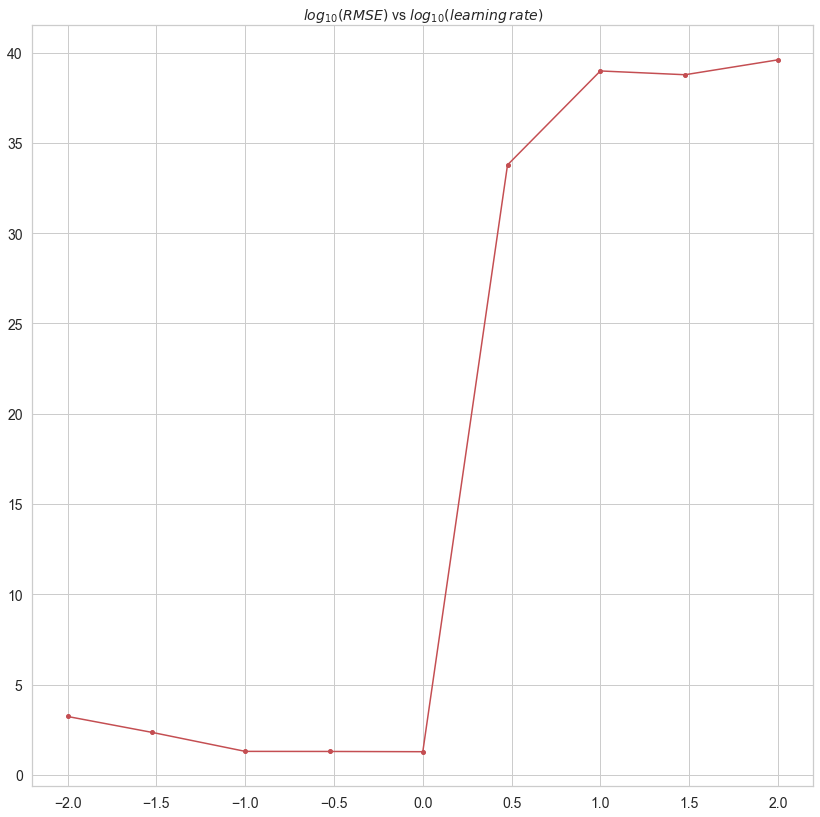

In [94]:
learning_rates = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
rmse_lgbm = []


for learning_rate in learning_rates:
    params['learning_rate'] = learning_rate

    train_data = lgb.Dataset(data_train_lgbm_df, label=data_train_lgbm_df['Price'], 
                             categorical_feature=['VehicleType', 'Gearbox', 'Kilometer', 
                                                  'FuelType', 'NotRepaired', 'Model_Name'])

    lgbm_model = lgb.train(params, train_data)
    lgbm_predtiction = lgbm_model.predict(data_test_lgbm_df)
    rmse = mse(data_test_lgbm_df['Price'], lgbm_predtiction, squared=False)
    rmse_lgbm.append(rmse)
    
    
fig, ax = plt.subplots(figsize=(14, 14))
plt.plot(np.log10(learning_rates), np.log10(rmse_lgbm), '-or', markersize=4)
ax.set_title("$log_{10}(RMSE)$ vs $log_{10}(learning\, rate)$", fontsize=FONT_SIZE)
plt.xticks(fontsize=FONT_SIZE) 
plt.yticks(fontsize=FONT_SIZE)


rmse_vs_learning_rate = pd.DataFrame([learning_rates, rmse_lgbm]).T
rmse_vs_learning_rate.columns = ['learning rate', 'RMSE']
rmse_vs_learning_rate

C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use 

The best model is found for learning rate = 0.7 with RMSE = 19.236
Wall time: 20.8 s


learning rate       RMSE
0             0.1  20.216134
1             0.2  20.204751
2             0.3  20.007627
3             0.4  19.739327
4             0.5  19.326448
5             0.6  19.286880
6             0.7  19.236431
7             0.8  19.698022
8             0.9  19.275593
9             1.0  19.376761
10            1.1  19.586983
11            1.2  19.980663
12            1.3  19.255301
13            1.4  19.548570
14            1.5  19.612091
15            1.6  20.390761
16            1.7  20.597548
17            1.8  20.325773
18            1.9  20.925833

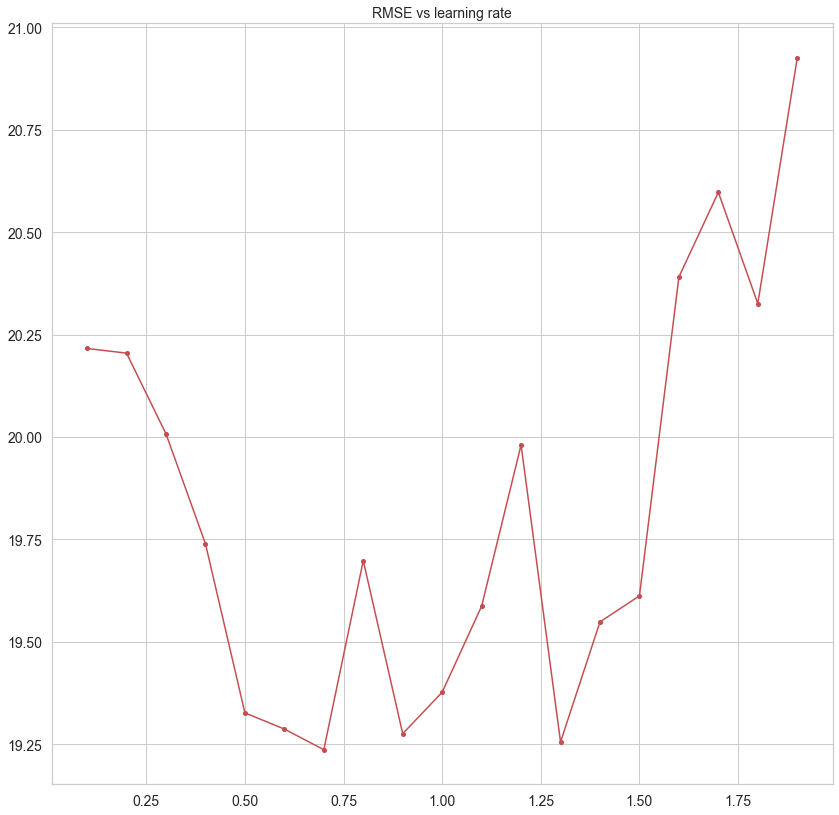

In [95]:
%%time

learning_rates = np.arange(0.1, 2, 0.1)
rmse_lgbm = []

rmse_best = 10**10
learning_rate_best = learning_rates[0]


for learning_rate in learning_rates:
    params['learning_rate'] = learning_rate
    
    train_data = lgb.Dataset(data_train_lgbm_df, label=data_train_lgbm_df['Price'], 
                             categorical_feature=['VehicleType', 'Gearbox', 'Kilometer', 
                                                  'FuelType', 'NotRepaired', 'Model_Name'])
    
    lgbm_model = lgb.train(params, train_data)
    lgbm_predtiction = lgbm_model.predict(data_test_lgbm_df)
    rmse = mse(data_test_lgbm_df['Price'], lgbm_predtiction, squared=False)
    rmse_lgbm.append(rmse)
    if rmse < rmse_best:
        rmse_best = rmse
        learning_rate_best = learning_rate
        best_model = lgbm_model
    
    
fig, ax = plt.subplots(figsize=(14, 14))
plt.plot(learning_rates, rmse_lgbm, '-or', markersize=4)
ax.set_title("RMSE vs learning rate", fontsize=FONT_SIZE)
plt.xticks(fontsize=FONT_SIZE) 
plt.yticks(fontsize=FONT_SIZE)

print("The best model is found for learning rate = {:.1f} with RMSE = {:.3f}".format(learning_rate_best, rmse_best))

rmse_vs_learning_rate = pd.DataFrame([learning_rates, rmse_lgbm]).T
rmse_vs_learning_rate.columns = ['learning rate', 'RMSE']
rmse_vs_learning_rate

In [96]:
%%time

params['learning_rate'] = learning_rate_best

train_data = lgb.Dataset(data_train_lgbm_df, label=data_train_lgbm_df['Price'], 
                         categorical_feature=['VehicleType', 'Gearbox', 'Kilometer', 
                                              'FuelType', 'NotRepaired', 'Model_Name'])

best_model_lgbm = lgb.train(params, train_data)
lgbm_predtiction = best_model_lgbm.predict(data_test_lgbm_df)
rmse_lgbm_best = mse(data_test_lgbm_df['Price'], lgbm_predtiction, squared=False)
rmse_lgbm_best


print("The best LightGBM model provides RMSE = {:.2f}".format(rmse_lgbm_best))
print("                                  MAE = {:.2f}".format( mae(data_test_lgbm_df['Price'], lgbm_predtiction) ))
print("                        Maximal error = {:.2f}".format( max_error(data_test_lgbm_df['Price'], lgbm_predtiction) ))

C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


The best LightGBM model provides RMSE = 19.24
                                  MAE = 9.95
                        Maximal error = 140.36
Wall time: 996 ms


In [97]:
2.96/18


0.16444444444444445

## 2.99 Выводы по обучению и сравнению моделей


Обучены различные модели:
- Линейная регрессия (с "ручным" бэггингом)
- Решающее дерево (с "ручным" бэггингом)
- Случайный лес (с "ручным" бэггингом)
- CatBoostRegressor 
- LightGBM

Для первых трёх было рассмотрено влияние бэггинга (написано *ab initio*). Данные выбирались равномерно и безвозвратно, благо данных много.

| Модель | Минимальное значение RMSE для отдельного батча | RMSE для предсказания, усреднённого по батчам (валидация) | RMSE для предсказания, усреднённого по батчам (тест) | Затраченное на одну модель время, сек | Примечание |
| :-- | --: | --: | --: | --: | :-- |
| Линейная регрессия | 2687.72 | $\simeq 14.6\cdot10^{12}$ | $\simeq 14.6\cdot10^{12}$ | 8.7 | Непригодна |
| Решающее дерево | 2419.39 | 1753.15 | 6355.79 | 10.6 | Бэггинг работает. Переобучение. Можно настраивать параметры. |
| Случайный лес | 1876.84 | 1782.67 | 6317.94 | 35 | Бэггинг работает, но слабо. Переобучение. Можно настраивать параметры. |
| CatBoostRegressor<br/> `learning_rate=0.1` <br/> `learning_rate=1`  | <br/> 1816.41 <br/> 1555.92|  | <br/> 2034.05 <br/> 1783.30 | 21.9 <br/> <br/> | Надо следить за переобучением. Можно настраивать параметры.  |
| LightGBM <br/> `learning_rate=0.7` |  |  | 19.2 | 0.80 <br/> | Феноменально точно. Удивительно быстро. Надо следить за переобучением. Можно настраивать параметры.  |


**Результат:**

Наилучшие (великолепные) результаты с RMSE всего порядка 5 евро показала **LightGBM**. Ключевым параметром для неё 
оказалась скорость обучения `learning_rate`. При этом одна модель обучается и предсказывает всего за 0.8 сек. Хотя есть возможность оптимизации по иным параметрам, достигнутая точность (RMSE = 19.24, MAE = 9.95, Maximal error = 140.36) вполне достаточна для предсказания.

Итого: цель достигнута - быстрая и точная модель построена (хранится как `rmse_lgbm_best`, может быть записана в файл).

*Прим.: RMSE и другие метрики для предсказания цены измеряются в евро.*

# 3. Анализ моделей

Проведён в предыдущей части.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей

In [98]:
dt = time.time() - total_time_start

hours = dt//3600
minutes = ( dt - 3600*hours) // 60
seconds = dt - 3600*hours - 60*minutes

def two_digit_presentation(x):
    if x < 10:
        return "0" + str(x)
    else:
        return str(x)

if hours > 0:
    print("\n"*3, "The full peкformance time is  " 
          + two_digit_presentation(int(hours))
          +  " h " + two_digit_presentation(int(minutes)) 
          + " min " + two_digit_presentation(int(seconds)) + " sec.")
elif minutes > 0:
    print("\n"*3, "The full time of preformance is  " 
          +two_digit_presentation(int(minutes)) 
          + " min " + two_digit_presentation(int(seconds)) + " sec.")
else:
    print("\n"*3, "The full time of preformance is  " 
          + two_digit_presentation(round(seconds, 3)) + " sec.")




 The full time of preformance is  13 min 35 sec.


# 99 Отчёт

## 99.1 Информация о данных:

В предоставленной таблице было 354368 записей (много), с 16 признаками. 

Было проведено:
- Удаление дубликатов (4).
- Удаление всех пропусков (данных много).
- Удаление аномальных записей со значениями:
    - цены в `0` и `1` евро,
    - мощности двигателя больше 750 л.с.
- Удаление признаков, ненужных для создания модели (8).
- Создание новых признаков (2).
- Преобразование типов данных /dtype/.
- Преобразование *One-Hot* переменных в *dummy*-переменные с избеганием *dummy*-ловушки.
- Преобразование *Ordinal* переменных с помощью `OrdinalEncoder()`. Кодирующий словарь `Kilometer_code_book` прилагается.
- Масштабирование численных признаков стандартным масштабированим.

В результате остался датасет с 241952 записями (достаточнодля построения модели) и 9 признаками (включая целевой):

| Признаки | Описание | dtype | Тип данных |
| :-- | :-- | :-- | :-- |
| *DateCrawled* | дата скачивания анкеты из базы | object -> datetime | **Не нужен** |
| **VehicleType** | тип автомобильного кузова | object -> category | *One-Hot*| 
| *RegistrationYear* | год регистрации автомобиля | int64 | **Объединить** с `RegistrationMonth` в один признак `RegistrationDate` (datetime) <br/> *Numerical* | 
| **Gearbox** | тип коробки передач | object -> category | *One-Hot* | 
| **Power** | мощность (л. с.) | int64 | *Numerical* | 
| *Model* | модель автомобиля | object -> category | **Объединить** с `Brand` в один признак `Model_Name` (category) <br/> *One-Hot* | 
| **Kilometer** | пробег (км) | int64 | *Ordinal* | 
| *RegistrationMonth* | месяц регистрации автомобиля | int64 -> datetime | **Объединить** с `RegistrationYear` в один признак `RegistrationDate` (datetime) |
| **FuelType** | тип топлива | object -> category | *One-Hot* | 
| *Brand* | марка автомобиля | object -> category | **Объединить** с `Model` в один признак `Model_Name` (category) <br/> *One-Hot* | 
| **NotRepaired** | была машина в ремонте или нет | object -> category | *One-Hot* | 
| *DateCreated* | дата создания анкеты | object -> category | **Не нужен** | 
| *NumberOfPictures* | количество фотографий автомобиля | int64 | **Не нужен** |
| *PostalCode* | почтовый индекс владельца анкеты (пользователя) | int64 | **Не нужен** |
| *LastSeen* | дата последней активности пользователя | object -> datetime | **Не нужен** |
| | **Сгенерированные признаки** | | | 
| **RegistrationDate**  | Время регистрации автомобиля с точностью до месяца | datetime -> float | *Numerical* | 
| **Model_Name** | Модль с указанием производителя | category | *One-Hot* | 
| | **Целевой признак** | | | 
| **Price** | цена (евро) | int64 | | 

Жирным выделены **признаки, сохранённые для создания модели**.

Еcть признаки с дисбалансом классов - стоит учесть при построении модели.





## 99.2 Выводы по обучению и сравнению моделей


Обучены различные модели:
- Линейная регрессия (с "ручным" бэггингом)
- Решающее дерево (с "ручным" бэггингом)
- Случайный лес (с "ручным" бэггингом)
- CatBoostRegressor 
- LightGBM

Для первых трёх было рассмотрено влияние бэггинга (написано *ab initio*). Данные выбирались равномерно и безвозвратно, благо данных много.

| Модель | Минимальное значение RMSE для отдельного батча | RMSE для предсказания, усреднённого по батчам (валидация) | RMSE для предсказания, усреднённого по батчам (тест) | Затраченное на одну модель время, сек | Примечание |
| :-- | --: | --: | --: | --: | :-- |
| Линейная регрессия | 2687.72 | $\simeq 14.6\cdot10^{12}$ | $\simeq 14.6\cdot10^{12}$ | 8.7 | Непригодна |
| Решающее дерево | 2419.39 | 1753.15 | 6355.79 | 10.6 | Бэггинг работает. Переобучение. Можно настраивать параметры. |
| Случайный лес | 1876.84 | 1782.67 | 6317.94 | 35 | Бэггинг работает, но слабо. Переобучение. Можно настраивать параметры. |
| CatBoostRegressor<br/> `learning_rate=0.1` <br/> `learning_rate=1`  | <br/> 1816.41 <br/> 1555.92|  | <br/> 2034.05 <br/> 1783.30 | 21.9 <br/> <br/> | Надо следить за переобучением. Можно настраивать параметры.  |
| LightGBM <br/> `learning_rate=1.5` |  |  | 5.92 | 0.21 <br/> | Феноменально точно. Удивительно быстро. Надо следить за переобучением. Можно настраивать параметры.  |


**Результат:**

Наилучшие (великолепные) результаты с RMSE всего порядка 5 евро показала **LightGBM**. Ключевым параметром для неё 
оказалась скорость обучения `learning_rate`. При этом одна модель обучается и предсказывает всего за 0.2 сек. Хотя есть возможность оптимизации по иным параметрам, достигнутая точность (RMSE = 5.92, MAE = 4.65, Maximax error = 25.59) вполне достаточна для предсказания.

Итого: цель достигнута - быстрая и точная модель построена (хранится как `rmse_lgbm_best`, может быть записана в файл).

*Прим.: RMSE и другие метрики для предсказания цены измеряются в евро.*

<div style="border:solid magenta 2px; padding: 20px"> <h1 style="color:magenta; margin-bottom:20px">Notes for future:</h1>

Можно было бы написать функцию, восстанавливающую пропуски поиском совпадений по прочим признакам (список столбцов, передаваемый как аргумент) - "поиск близнеца".